# Project 2: Sentiment Analysis

## Part I: Bloomberg Inflation Analysis

In [1]:
#from newsapi import NewsApiClient
import pandas as pd
import numpy as np
import csv

In [139]:
api = NewsApiClient(api_key='YOUR API KEY')
all_articles = api.get_everything(qintitle='inflation', sources='bloomberg', from_param='2022-12-10', to='2022-01-09', language='en')
all_articles = all_articles['articles']

### Filter away Podcast and Radio & Save as csv file

In [3]:
filter_criteria = ['/audio/']
filtered_allArticles = []
for i in range(len(all_articles)):
    blocked = False
    for item in filter_criteria:
        if item in all_articles[i]['url']:
            blocked = True
            break
    if blocked == False:
        filtered_allArticles.append(all_articles[i])

In [4]:
filtered_allArticles = pd.DataFrame (filtered_allArticles, columns = ['source', 'author', 'title', 'discription', 'url', 'urlToImage', 'publishedAt', 'content'])

In [5]:
filtered_allArticles.to_csv('filtered_allArticles.csv', index=False, header=True)

## Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import re
import pickle
import nltk
import logging
import multiprocessing
from datetime import datetime
from re import sub
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from time import time 
from unidecode import unidecode
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet
import spacy 
import stanza 
import spacy_stanza
from negspacy.negation import Negex
from negspacy.termsets import termset 

[nltk_data] Downloading package punkt to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
filtered_allArticles = pd.read_csv('filtered_allArticles.csv')
filtered_allArticles.head(3)

,source,author,title,discription,url,urlToImage,publishedAt,content,Cleaned_content,POS tagged,Lemma
0,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Simon Kennedy,'Polycrisis' Inflation,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-05T12:00:14Z,Hello. Today we look at inflation at times of ...,hello today we look at inflation at times of e...,"[('hello', 'n'), ('today', 'n'), ('look', 'v')...",hello today look inflation time economic str...
1,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,Inflation Watch,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/s3/javelin/public/javel...,2022-12-13T12:00:16Z,Hello. Today we brace for the latest US inflat...,hello today we brace for the latest us inflati...,"[('hello', 'n'), ('today', 'n'), ('brace', 'v'...",hello today brace late us inflation read exa...
2,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,An Underappreciated Inflation Loser Is Wenatch...,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-16T12:00:16Z,Hello. Today we look at the costliest US citie...,hello today we look at the costliest us cities...,"[('hello', 'n'), ('today', 'n'), ('look', 'v')...",hello today look costly us city world cup ec...


### Clean the text

In [3]:
sep = ' … '
for i in range(len(filtered_allArticles)):
    filtered_allArticles['content'][i] = filtered_allArticles['content'][i].split(sep, 1)[0]

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_3588\3768427590.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_allArticles['content'][i] = filtered_allArticles['content'][i].split(sep, 1)[0]


In [4]:
# Define a function to clean the text
def text_to_word_list(text):
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)

    return text

# Cleaning the text in the column
filtered_allArticles['Cleaned_content'] = filtered_allArticles['content'].apply(text_to_word_list)
filtered_allArticles.head()

,source,author,title,discription,url,urlToImage,publishedAt,content,Cleaned_content,POS tagged,Lemma
0,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Simon Kennedy,'Polycrisis' Inflation,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-05T12:00:14Z,Hello. Today we look at inflation at times of ...,hello today we look at inflation at times of e...,"[('hello', 'n'), ('today', 'n'), ('look', 'v')...",hello today look inflation time economic str...
1,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,Inflation Watch,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/s3/javelin/public/javel...,2022-12-13T12:00:16Z,Hello. Today we brace for the latest US inflat...,hello today we brace for the latest us inflati...,"[('hello', 'n'), ('today', 'n'), ('brace', 'v'...",hello today brace late us inflation read exa...
2,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,An Underappreciated Inflation Loser Is Wenatch...,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-16T12:00:16Z,Hello. Today we look at the costliest US citie...,hello today we look at the costliest us cities...,"[('hello', 'n'), ('today', 'n'), ('look', 'v')...",hello today look costly us city world cup ec...
3,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Charlie Wells,Bloomberg Wealth: Has Inflation Finally Peaked?,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-15T11:30:18Z,To the relief of consumers and policymakers al...,to the relief of consumers and policymakers al...,"[('relief', 'n'), ('consumers', 'n'), ('policy...",relief consumer policymakers alike appear in...
4,"{'id': 'bloomberg', 'name': 'Bloomberg'}","Joe Weisenthal, Tracy Alloway",Where Things Stand Now With Inflation and the Fed,NaN,https://www.bloomberg.com/news/articles/2022-1...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-19T09:00:17Z,Listen to Odd Lots on Apple PodcastsListen to ...,listen to odd lots on apple podcastslisten to ...,"[('listen', 'n'), ('odd', 'a'), ('lots', 'n'),...",listen odd lot apple podcastslisten odd lot ...


### Tokenization, Stopwords Removal, POS Tagging

In [5]:
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

filtered_allArticles['POS tagged'] = filtered_allArticles['Cleaned_content'].apply(token_stop_pos)
filtered_allArticles.head()

,source,author,title,discription,url,urlToImage,publishedAt,content,Cleaned_content,POS tagged,Lemma
0,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Simon Kennedy,'Polycrisis' Inflation,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-05T12:00:14Z,Hello. Today we look at inflation at times of ...,hello today we look at inflation at times of e...,"[(hello, n), (today, n), (look, v), (inflation...",hello today look inflation time economic str...
1,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,Inflation Watch,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/s3/javelin/public/javel...,2022-12-13T12:00:16Z,Hello. Today we brace for the latest US inflat...,hello today we brace for the latest us inflati...,"[(hello, n), (today, n), (brace, v), (latest, ...",hello today brace late us inflation read exa...
2,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,An Underappreciated Inflation Loser Is Wenatch...,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-16T12:00:16Z,Hello. Today we look at the costliest US citie...,hello today we look at the costliest us cities...,"[(hello, n), (today, n), (look, v), (costliest...",hello today look costly us city world cup ec...
3,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Charlie Wells,Bloomberg Wealth: Has Inflation Finally Peaked?,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-15T11:30:18Z,To the relief of consumers and policymakers al...,to the relief of consumers and policymakers al...,"[(relief, n), (consumers, n), (policymakers, n...",relief consumer policymakers alike appear in...
4,"{'id': 'bloomberg', 'name': 'Bloomberg'}","Joe Weisenthal, Tracy Alloway",Where Things Stand Now With Inflation and the Fed,NaN,https://www.bloomberg.com/news/articles/2022-1...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-19T09:00:17Z,Listen to Odd Lots on Apple PodcastsListen to ...,listen to odd lots on apple podcastslisten to ...,"[(listen, n), (odd, a), (lots, n), (apple, n),...",listen odd lot apple podcastslisten odd lot ...


### Obtaining the stem words – Lemmatization

A stem is a part of a word responsible for its lexical meaning. The two popular techniques of obtaining the root/stem words are Stemming and Lemmatization.

The key difference is Stemming often gives some meaningless root words as it simply chops off some characters in the end. Lemmatization gives meaningful root words, however, it requires POS tags of the words, and that's the reason why I build the POS tags in the previous step.

Lemmatize is a function that takes pos_tag tuples, and gives the Lemma for each word in pos_tag based on the pos of that word. We applied it to the ‘POS tagged’ column and created a column ‘Lemma’ to store the output.

In [6]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

filtered_allArticles['Lemma'] = filtered_allArticles['POS tagged'].apply(lemmatize)
filtered_allArticles.head()

,source,author,title,discription,url,urlToImage,publishedAt,content,Cleaned_content,POS tagged,Lemma
0,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Simon Kennedy,'Polycrisis' Inflation,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-05T12:00:14Z,Hello. Today we look at inflation at times of ...,hello today we look at inflation at times of e...,"[(hello, n), (today, n), (look, v), (inflation...",hello today look inflation time economic str...
1,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,Inflation Watch,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/s3/javelin/public/javel...,2022-12-13T12:00:16Z,Hello. Today we brace for the latest US inflat...,hello today we brace for the latest us inflati...,"[(hello, n), (today, n), (brace, v), (latest, ...",hello today brace late us inflation read exa...
2,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Chris Anstey,An Underappreciated Inflation Loser Is Wenatch...,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-16T12:00:16Z,Hello. Today we look at the costliest US citie...,hello today we look at the costliest us cities...,"[(hello, n), (today, n), (look, v), (costliest...",hello today look costly us city world cup ec...
3,"{'id': 'bloomberg', 'name': 'Bloomberg'}",Charlie Wells,Bloomberg Wealth: Has Inflation Finally Peaked?,NaN,https://www.bloomberg.com/news/newsletters/202...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-15T11:30:18Z,To the relief of consumers and policymakers al...,to the relief of consumers and policymakers al...,"[(relief, n), (consumers, n), (policymakers, n...",relief consumer policymakers alike appear in...
4,"{'id': 'bloomberg', 'name': 'Bloomberg'}","Joe Weisenthal, Tracy Alloway",Where Things Stand Now With Inflation and the Fed,NaN,https://www.bloomberg.com/news/articles/2022-1...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2022-12-19T09:00:17Z,Listen to Odd Lots on Apple PodcastsListen to ...,listen to odd lots on apple podcastslisten to ...,"[(listen, n), (odd, a), (lots, n), (apple, n),...",listen odd lot apple podcastslisten odd lot ...


In [7]:
filtered_allArticles.to_csv('fin_allArticles.csv', index=False, header=True)

### TextBlob

TextBlob is a Python library for processing textual data. It provides a consistent API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, and more.

The two measures that are used to analyze the sentiment are:

- Polarity – talks about how positive or negative the opinion is

- Subjectivity – talks about how subjective the opinion is

TextBlob(text).sentiment gives us the Polarity, Subjectivity values.

Polarity ranges from -1 to 1 (1 is more positive, 0 is neutral, -1 is more negative)

Subjectivity ranges from 0 to 1(0 being very objective and 1 being very subjective)

In [8]:
fin_data = pd.DataFrame(filtered_allArticles[['content', 'Lemma']])
fin_data

,content,Lemma
0,Hello. Today we look at inflation at times of ...,hello today look inflation time economic str...
1,Hello. Today we brace for the latest US inflat...,hello today brace late us inflation read exa...
2,Hello. Today we look at the costliest US citie...,hello today look costly us city world cup ec...
3,To the relief of consumers and policymakers al...,relief consumer policymakers alike appear in...
4,Listen to Odd Lots on Apple PodcastsListen to ...,listen odd lot apple podcastslisten odd lot ...
...,...,...
63,The worlds biggest central banks will this wee...,world big central bank week wrap aggressive ...
64,"Stubbornly high inflation, soaring borrowing c...",stubbornly high inflation soar borrowing cos...
65,Australias central bank is playing with fire i...,australias central bank play fire signal hig...
66,Annie Taylor was about to drop $100 on a new p...,annie taylor drop 100 new pair steve madden ...


In [9]:
from textblob import TextBlob

# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [10]:
fin_data['Subjectivity'] = fin_data['Lemma'].apply(getSubjectivity) 
fin_data['Polarity'] = fin_data['Lemma'].apply(getPolarity) 
fin_data['Analysis'] = fin_data['Polarity'].apply(analysis)
fin_data.head()

,content,Lemma,Subjectivity,Polarity,Analysis
0,Hello. Today we look at inflation at times of ...,hello today look inflation time economic str...,0.200000,0.200000,Positive
1,Hello. Today we brace for the latest US inflat...,hello today brace late us inflation read exa...,0.351515,-0.054545,Negative
2,Hello. Today we look at the costliest US citie...,hello today look costly us city world cup ec...,0.270000,0.120000,Positive
3,To the relief of consumers and policymakers al...,relief consumer policymakers alike appear in...,0.600000,0.000000,Neutral
4,Listen to Odd Lots on Apple PodcastsListen to ...,listen odd lot apple podcastslisten odd lot ...,0.263333,0.003333,Positive


In [11]:
tb_counts = fin_data.Analysis.value_counts()
tb_counts

Positive    35
Negative    23
Neutral     10
Name: Analysis, dtype: int64

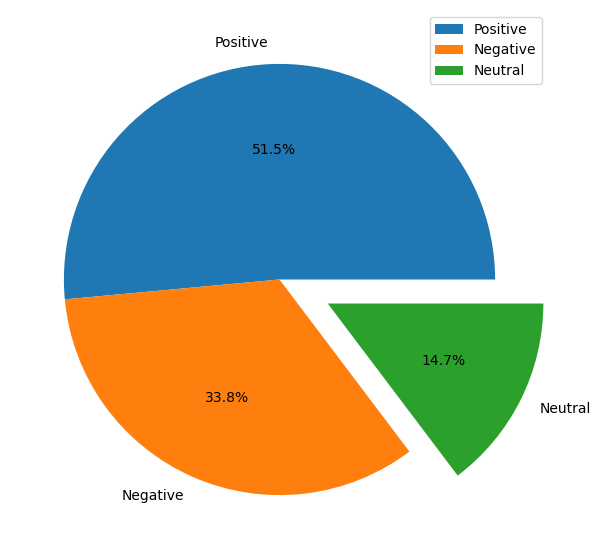

In [12]:
plt.figure(figsize=(10, 7))
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.legend();

### VADER

VADER stands for Valence Aware Dictionary and Sentiment Reasoner. Vader sentiment not only tells if the statement is positive or negative along with the intensity of emotion.
The sum of pos, neg, neu intensities give 1. Compound ranges from -1 to 1 and is the metric used to draw the overall sentiment.
- positive if compound >= 0.5
- neutral if -0.5 < compound < 0.5
- negative if -0.5 >= compound

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
fin_data['Vader Sentiment'] = fin_data['Lemma'].apply(vadersentimentanalysis)

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
        
fin_data['Vader Analysis'] = fin_data['Vader Sentiment'].apply(vader_analysis)
fin_data.head()

,content,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis
0,Hello. Today we look at inflation at times of ...,hello today look inflation time economic str...,0.200000,0.200000,Positive,-0.6597,Negative
1,Hello. Today we brace for the latest US inflat...,hello today brace late us inflation read exa...,0.351515,-0.054545,Negative,-0.2960,Neutral
2,Hello. Today we look at the costliest US citie...,hello today look costly us city world cup ec...,0.270000,0.120000,Positive,0.5994,Positive
3,To the relief of consumers and policymakers al...,relief consumer policymakers alike appear in...,0.600000,0.000000,Neutral,0.6597,Positive
4,Listen to Odd Lots on Apple PodcastsListen to ...,listen odd lot apple podcastslisten odd lot ...,0.263333,0.003333,Positive,-0.2516,Neutral


In [14]:
vader_counts = fin_data['Vader Analysis'].value_counts()
vader_counts

Neutral     45
Positive    16
Negative     7
Name: Vader Analysis, dtype: int64

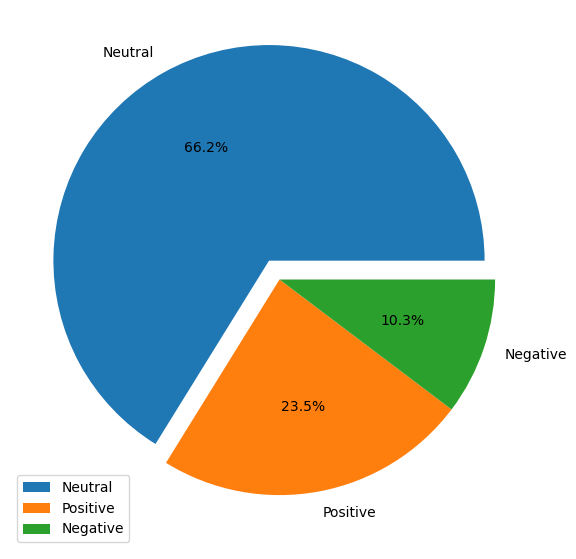

In [15]:
plt.figure(figsize=(10, 7))
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)
plt.legend();

### SentiWordNet

In [16]:
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn

def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
        # print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
    if not tokens_count:
        return 0
    if sentiment>0:
        return "Positive"
    if sentiment==0:
        return "Neutral"
    else:
        return "Negative"

fin_data['SWN analysis'] = filtered_allArticles['POS tagged'].apply(sentiwordnetanalysis)
fin_data.head()

[nltk_data] Downloading package sentiwordnet to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


,content,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,SWN analysis
0,Hello. Today we look at inflation at times of ...,hello today look inflation time economic str...,0.200000,0.200000,Positive,-0.6597,Negative,Neutral
1,Hello. Today we brace for the latest US inflat...,hello today brace late us inflation read exa...,0.351515,-0.054545,Negative,-0.2960,Neutral,Negative
2,Hello. Today we look at the costliest US citie...,hello today look costly us city world cup ec...,0.270000,0.120000,Positive,0.5994,Positive,Positive
3,To the relief of consumers and policymakers al...,relief consumer policymakers alike appear in...,0.600000,0.000000,Neutral,0.6597,Positive,Positive
4,Listen to Odd Lots on Apple PodcastsListen to ...,listen odd lot apple podcastslisten odd lot ...,0.263333,0.003333,Positive,-0.2516,Neutral,Positive


In [17]:
swn_counts= fin_data['SWN analysis'].value_counts()
swn_counts

Positive    36
Negative    27
Neutral      5
Name: SWN analysis, dtype: int64

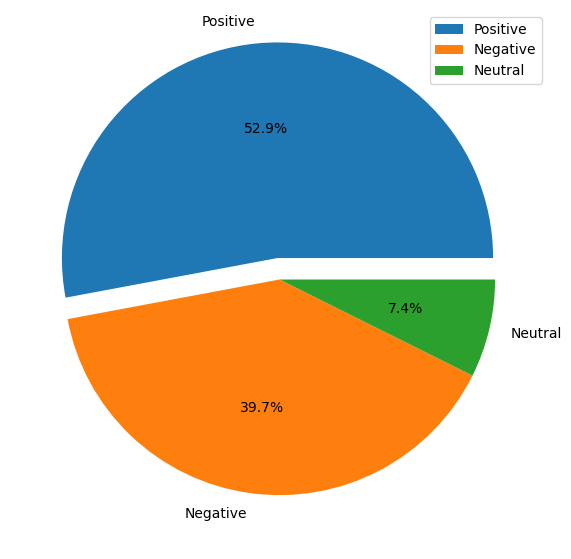

In [18]:
plt.figure(figsize=(10, 7))
plt.pie(swn_counts.values, labels = swn_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)
plt.legend();

### Selection

In [19]:
for i in range(len(fin_data)):
    if fin_data['Analysis'][i] == 'Positive':
        fin_data['Analysis'][i] = 1
    elif fin_data['Analysis'][i] == 'Negative':
        fin_data['Analysis'][i] = -1
    else:
        fin_data['Analysis'][i] = 0

    if fin_data['Vader Analysis'][i] == 'Positive':
        fin_data['Vader Analysis'][i] = 1
    elif fin_data['Vader Analysis'][i] == 'Negative':
        fin_data['Vader Analysis'][i] = -1
    else:
        fin_data['Vader Analysis'][i] = 0

    if fin_data['SWN analysis'][i] == 'Positive':
        fin_data['SWN analysis'][i] = 1
    elif fin_data['SWN analysis'][i] == 'Negative':
        fin_data['SWN analysis'][i] = -1
    else:
        fin_data['SWN analysis'][i] = 0

fin_data['finalSentiment'] = [0] * len(fin_data)
for i in range(len(fin_data)):
    fin_data['finalSentiment'][i] = fin_data['Analysis'][i] + fin_data['Vader Analysis'][i] + fin_data['SWN analysis'][i]

fin_data['Res'] = fin_data['finalSentiment']
for i in range(len(fin_data)):
    if fin_data['finalSentiment'][i] == 3:
        fin_data['Res'][i] = 'Strong Positive'
    elif fin_data['finalSentiment'][i] == 2:
        fin_data['Res'][i] = 'Positive'
    elif -1 <= fin_data['finalSentiment'][i] <= 1:
        fin_data['Res'][i] = 'Neutral'
    elif fin_data['finalSentiment'][i] == -2:
        fin_data['Res'][i] = 'Negative'
    elif fin_data['finalSentiment'][i] == -3:
        fin_data['Res'][i] = 'Stong Negative'

fin_data.head(3)

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_3588\950749786.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_data['Analysis'][i] = 1
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_3588\950749786.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_data['Vader Analysis'][i] = -1
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_3588\950749786.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_data['SWN 

,content,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,SWN analysis,finalSentiment,Res
0,Hello. Today we look at inflation at times of ...,hello today look inflation time economic str...,0.200000,0.200000,1,-0.6597,-1,0,0,Neutral
1,Hello. Today we brace for the latest US inflat...,hello today brace late us inflation read exa...,0.351515,-0.054545,-1,-0.2960,0,-1,-2,Negative
2,Hello. Today we look at the costliest US citie...,hello today look costly us city world cup ec...,0.270000,0.120000,1,0.5994,1,1,3,Strong Positive


In [20]:
fin_data.to_csv('fin_data.csv', index=False, header=True)

In [21]:
fin_data

,content,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,SWN analysis,finalSentiment,Res
0,Hello. Today we look at inflation at times of ...,hello today look inflation time economic str...,0.200000,0.200000,1,-0.6597,-1,0,0,Neutral
1,Hello. Today we brace for the latest US inflat...,hello today brace late us inflation read exa...,0.351515,-0.054545,-1,-0.2960,0,-1,-2,Negative
2,Hello. Today we look at the costliest US citie...,hello today look costly us city world cup ec...,0.270000,0.120000,1,0.5994,1,1,3,Strong Positive
3,To the relief of consumers and policymakers al...,relief consumer policymakers alike appear in...,0.600000,0.000000,0,0.6597,1,1,2,Positive
4,Listen to Odd Lots on Apple PodcastsListen to ...,listen odd lot apple podcastslisten odd lot ...,0.263333,0.003333,1,-0.2516,0,1,2,Positive
...,...,...,...,...,...,...,...,...,...,...
63,The worlds biggest central banks will this wee...,world big central bank week wrap aggressive ...,0.250000,-0.100000,-1,-0.0516,0,1,0,Neutral
64,"Stubbornly high inflation, soaring borrowing c...",stubbornly high inflation soar borrowing cos...,0.151667,0.040000,1,-0.5859,-1,-1,-1,Neutral
65,Australias central bank is playing with fire i...,australias central bank play fire signal hig...,0.385000,-0.010000,-1,0.2960,0,0,-1,Neutral
66,Annie Taylor was about to drop $100 on a new p...,annie taylor drop 100 new pair steve madden ...,0.260606,-0.015152,-1,-0.2732,0,1,0,Neutral


### Visualization

### Sentiment Scores for Inflation News

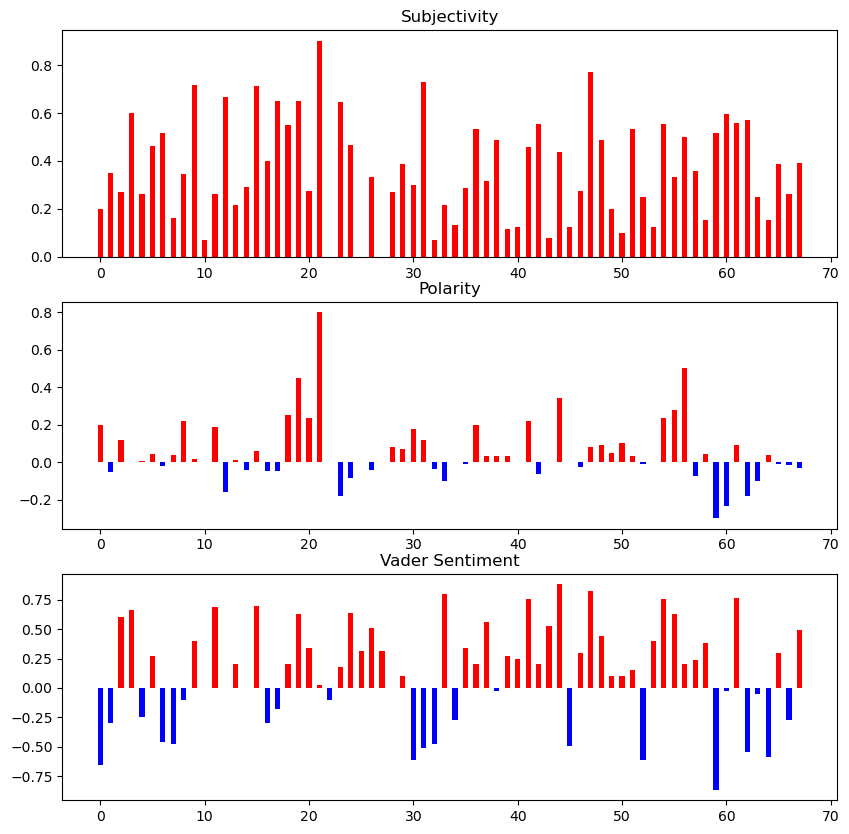

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

plt.close('all')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0.2})
fig.set_figheight(10)
fig.set_figwidth(10)
ax = plt.subplot(111)    # The big subplot
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
ax1.bar(fin_data[fin_data['Subjectivity'] > 0]['Subjectivity'].index, fin_data[fin_data['Subjectivity'] > 0]['Subjectivity'], width = 0.5, color='r')
ax1.bar(fin_data[fin_data['Subjectivity'] < 0]['Subjectivity'].index, fin_data[fin_data['Subjectivity'] < 0]['Subjectivity'], width=0.5, color='b')
ax2.bar(fin_data[fin_data['Polarity'] > 0]['Polarity'].index, fin_data[fin_data['Polarity'] > 0]['Polarity'], width = 0.5, color='r')
ax2.bar(fin_data[fin_data['Polarity'] < 0]['Polarity'].index, fin_data[fin_data['Polarity'] < 0]['Polarity'], width = 0.5, color='b')
ax3.bar(fin_data[fin_data['Vader Sentiment'] > 0]['Vader Sentiment'].index, fin_data[fin_data['Vader Sentiment'] > 0]['Vader Sentiment'], width=0.5, color='r')
ax3.bar(fin_data[fin_data['Vader Sentiment'] < 0]['Vader Sentiment'].index, fin_data[fin_data['Vader Sentiment'] < 0]['Vader Sentiment'], width=0.5, color='b')

# Set common labels
ax.set_xlabel('News')
ax.set_ylabel('Score')

ax1.set_title('Subjectivity')
ax2.set_title('Polarity')
ax3.set_title('Vader Sentiment')

plt.savefig('Sentiment Scores for Inflation News.png', dpi=300);

### Time series chart of rolling 5 period mean of Vader Sentiment


In [78]:
vader_rolling_df = pd.DataFrame({'Vader Sentiment': fin_data['Vader Sentiment'], 'PublishedAt': filtered_allArticles['publishedAt']})
vader_rolling_df

,Vader Sentiment,PublishedAt
0,-0.6597,2022-12-05T12:00:14Z
1,-0.2960,2022-12-13T12:00:16Z
2,0.5994,2022-12-16T12:00:16Z
3,0.6597,2022-12-15T11:30:18Z
4,-0.2516,2022-12-19T09:00:17Z
...,...,...
63,-0.0516,2022-12-10T22:06:06Z
64,-0.5859,2022-12-21T05:55:57Z
65,0.2960,2022-12-01T04:38:01Z
66,-0.2732,2022-12-20T16:16:17Z


In [79]:
new_format = "%Y-%m-%d"
for i in range(len(vader_rolling_df)):
    vader_rolling_df['PublishedAt'][i] = datetime.strptime(vader_rolling_df['PublishedAt'][i], "%Y-%m-%dT%H:%M:%SZ")  # "%Y-%m-%dT%H:%M:%SZ"
    vader_rolling_df['PublishedAt'][i] = vader_rolling_df['PublishedAt'][i].strftime(new_format)

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_3588\2567795267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_rolling_df['PublishedAt'][i] = datetime.strptime(vader_rolling_df['PublishedAt'][i], "%Y-%m-%dT%H:%M:%SZ")  # "%Y-%m-%dT%H:%M:%SZ"
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_3588\2567795267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_rolling_df['PublishedAt'][i] = vader_rolling_df['PublishedAt'][i].strftime(new_format)


In [80]:
vader_rolling_df = vader_rolling_df.sort_values('PublishedAt').reset_index(drop=True)
vader_rolling_df

,Vader Sentiment,PublishedAt
0,0.7964,2022-11-29
1,0.1027,2022-11-30
2,0.5574,2022-11-30
3,-0.4767,2022-11-30
4,0.2960,2022-12-01
...,...,...
63,0.1027,2022-12-23
64,-0.0258,2022-12-23
65,0.2023,2022-12-23
66,0.0000,2022-12-23


In [81]:
vader_rolling_group = vader_rolling_df.groupby('PublishedAt')['Vader Sentiment'].sum().rolling(5).mean()
vader_rolling_group_df = pd.DataFrame({'PublishedAt':vader_rolling_group.index, 'Rolling Mean Score':vader_rolling_group.values})
vader_rolling_group_df

,PublishedAt,Rolling Mean Score
0,2022-11-29,NaN
1,2022-11-30,NaN
2,2022-12-01,NaN
3,2022-12-02,NaN
4,2022-12-03,0.26522
5,2022-12-04,0.15282
6,2022-12-05,-0.01580
7,2022-12-06,0.05190
8,2022-12-07,0.13660
9,2022-12-08,0.44446


In [83]:
vader_rolling_plot = vader_rolling_df.groupby('PublishedAt')['Vader Sentiment'].sum()
vader_rolling_plot_df = pd.DataFrame({'PublishedAt':vader_rolling_plot.index, 'Daily Score':vader_rolling_plot.values})
vader_rolling_plot_df

,PublishedAt,Daily Score
0,2022-11-29,0.7964
1,2022-11-30,0.1834
2,2022-12-01,0.5322
3,2022-12-02,0.6830
4,2022-12-03,-0.8689
5,2022-12-04,0.2344
6,2022-12-05,-0.6597
7,2022-12-06,0.8707
8,2022-12-07,1.1065
9,2022-12-08,0.6704


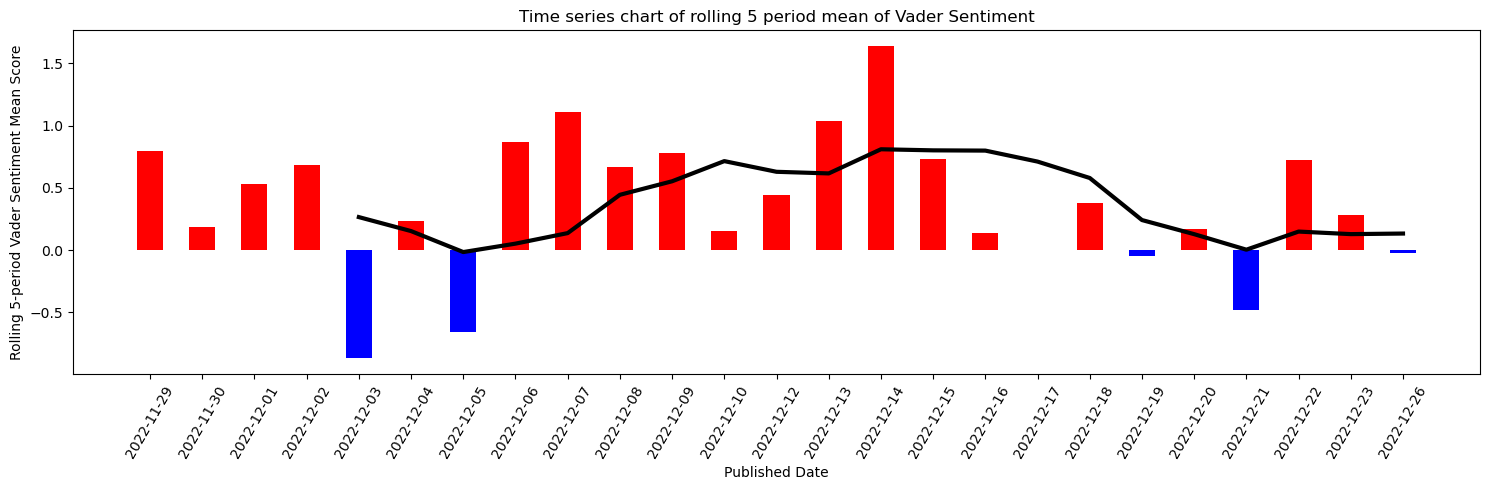

In [88]:
fig, ax = plt.subplots(1, 1, sharex=True, gridspec_kw={'hspace': 0})
fig.set_figheight(5)
fig.set_figwidth(15)
ax = plt.subplot(111)
ax.plot(vader_rolling_group_df['PublishedAt'], vader_rolling_group_df['Rolling Mean Score'], linewidth=3, color='black')
ax.bar(vader_rolling_plot_df[vader_rolling_plot_df['Daily Score'] > 0]['PublishedAt'], vader_rolling_plot_df[vader_rolling_plot_df['Daily Score'] > 0]['Daily Score'], width=0.5, color='r')
ax.bar(vader_rolling_plot_df[vader_rolling_plot_df['Daily Score'] < 0]['PublishedAt'], vader_rolling_plot_df[vader_rolling_plot_df['Daily Score'] < 0]['Daily Score'], width = 0.5, color='b')

# Set common labels
ax.set_xlabel('Published Date')
ax.set_ylabel('Rolling 5-period Vader Sentiment Mean Score')
ax.set_title('Time series chart of rolling 5 period mean of Vader Sentiment')
plt.xticks(rotation=60)
fig.set_tight_layout(True)
plt.savefig('Time series chart of rolling 5 period mean of Vader Sentiment.png', dpi=300);

## Part II: Twitter Analysis

### Connect API

In [3]:
import tweepy
 
# API keyws that yous saved earlier
api_key = 'YOUR API KEY'
api_secret_key = "YOUR API KEY"
access_token = 'YOUR ACCESS TOKEN'
access_token_secret = 'YOUR ACCESS TOKEN SECRET'
bearer_token = 'YOUR BEARER TOKEN'

# Authenticate to Twitter
auth = tweepy.OAuthHandler(api_key,api_secret_key)
auth.set_access_token(access_token,access_token_secret)

api = tweepy.API(auth)
 
try:
    api.verify_credentials()
    print('Successful Authentication')
except:
    print('Failed authentication')

Successful Authentication


### Get Tweets

#### Bloomberg

In [20]:
import csv
import os
import re
from re import sub
import tweepy
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tkinter import *
import base64
from tkinter import messagebox
import tkinter.font as font
import tk
import snscrape.modules.twitter as sntwitter

In [5]:
columns = ["Date Created", "Tweet", 'label']
bbg_df = pd.DataFrame(columns=columns)
#csvFile = open('bloomberg_data.csv', 'r')
#csvWriter = csv.writer(csvFile)
date_created = []
tweets = []
username = "markets"

for tweet in tweepy.Cursor(api.user_timeline, screen_name=username, tweet_mode='extended').items():
    if 'RT' in tweet.full_text:
        continue
    date_created.append(tweet.created_at)
    tweets.append(tweet.full_text)
    #csvWriter.writerow([tweet.created_at, tweet.full_text])
#csvFile.close()

bbg_df['Date Created'] = date_created
bbg_df['Tweet'] = tweets
bbg_df['label'] = ['BBG']*len(bbg_df)
bbg_df.to_csv('bloomberg_data.csv', index=False, header=True)

In [6]:
bbg_df

,Date Created,Tweet,label
0,2023-01-04 23:53:39+00:00,New Jersey extended its contract with Horizon ...,BBG
1,2023-01-04 23:34:00+00:00,"Eurozone PPI, earnings, jobless claims and mor...",BBG
2,2023-01-04 23:25:16+00:00,Cineworld may strike a new in-theater advertis...,BBG
3,2023-01-04 23:21:18+00:00,Brazilian hedge funds profited from everything...,BBG
4,2023-01-04 23:09:46+00:00,Saudi Arabia kept oil exports steady last mont...,BBG
...,...,...,...
2608,2022-11-23 01:51:00+00:00,Cathie Wood says she trusts crypto despite FTX...,BBG
2609,2022-11-23 01:35:00+00:00,Cathie Wood says Bitcoin will be worth $1 mill...,BBG
2610,2022-11-23 01:29:20+00:00,New Zealand’s central bank raises interest rat...,BBG
2611,2022-11-23 01:19:22+00:00,NEW: China has made its green bond market cent...,BBG


#### FT

In [7]:
columns = ["Date Created", "Tweet", 'label']
FT_df = pd.DataFrame(columns=columns)
#csvFile = open('FT_data.csv', 'a')
#csvWriter = csv.writer(csvFile)
date_created = []
tweets = []
username = "FT"

for tweet in tweepy.Cursor(api.user_timeline, screen_name=username, tweet_mode='extended').items():
    if 'RT' in tweet.full_text:
        continue
    date_created.append(tweet.created_at)
    tweets.append(tweet.full_text)
    #csvWriter.writerow([tweet.created_at, tweet.full_text])
#csvFile.close()

FT_df['Date Created'] = date_created
FT_df['Tweet'] = tweets
FT_df['label'] = ['FT']*len(FT_df)
FT_df.to_csv('FT_data.csv', index=False, header=True)

In [8]:
FT_df

,Date Created,Tweet,label
0,2023-01-05 00:05:49+00:00,UK needs ‘war effort’ to cut energy bills and ...,FT
1,2023-01-04 23:15:52+00:00,PPE Medpro gave ‘invalid’ accreditation for go...,FT
2,2023-01-04 22:53:33+00:00,Live updates: Brussels ‘strongly’ urges Covid ...,FT
3,2023-01-04 22:40:06+00:00,Kevin McCarthy and the crisis of Republican go...,FT
4,2023-01-04 22:33:19+00:00,Foxconn’s biggest Chinese rival wins premium i...,FT
...,...,...,...
3230,2022-09-30 07:35:10+00:00,Truss and Kwarteng to meet OBR in effort to re...,FT
3231,2022-09-30 07:24:01+00:00,UK house price growth stalls as rate rises pin...,FT
3232,2022-09-30 05:57:29+00:00,Five lessons from Britain’s bad week https://t...,FT
3233,2022-09-30 05:02:12+00:00,Lula takes dominant lead as Brazil election en...,FT


#### WSJ

In [9]:
columns = ["Date Created", "Tweet", 'label']
WSJ_df = pd.DataFrame(columns=columns)
#csvFile = open('WSJ_data.csv', 'a')
#csvWriter = csv.writer(csvFile)
date_created = []
tweets = []
username = "WSJ"

for tweet in tweepy.Cursor(api.user_timeline, screen_name=username, tweet_mode='extended').items():
    if 'RT' in tweet.full_text:
        continue
    date_created.append(tweet.created_at)
    tweets.append(tweet.full_text)
    #csvWriter.writerow([tweet.created_at, tweet.full_text])
#csvFile.close()

WSJ_df['Date Created'] = date_created
WSJ_df['Tweet'] = tweets
WSJ_df['label'] = ['WSJ']*len(WSJ_df)
WSJ_df.to_csv('WSJ_data.csv', index=False, header=True)

In [10]:
WSJ_df

,Date Created,Tweet,label
0,2023-01-05 00:45:04+00:00,European Union member states agreed to control...,WSJ
1,2023-01-05 00:30:08+00:00,"Cineworld, owner of Regal Cinemas, said it con...",WSJ
2,2023-01-05 00:20:04+00:00,From @WSJopinion: The social-justice activism ...,WSJ
3,2023-01-05 00:10:05+00:00,Streaming software giant Roku has launched its...,WSJ
4,2023-01-05 00:00:13+00:00,Some schools are reducing out-of-school suspen...,WSJ
...,...,...,...
3190,2022-12-01 15:55:02+00:00,Six million people remained without power acro...,WSJ
3191,2022-12-01 15:45:07+00:00,Georgia’s runoff between Democrat Raphael Warn...,WSJ
3192,2022-12-01 15:30:11+00:00,Applications for U.S. unemployment benefits fe...,WSJ
3193,2022-12-01 15:15:09+00:00,"Nearly 50,000 academic workers picketed ten Un...",WSJ


#### TheEconomist

In [11]:
columns = ["Date Created", "Tweet", 'label']
econ_df = pd.DataFrame(columns=columns)
#csvFile = open('Econ_data.csv', 'a')
#csvWriter = csv.writer(csvFile)
date_created = []
tweets = []
username = "TheEconomist"

for tweet in tweepy.Cursor(api.user_timeline, screen_name=username, tweet_mode='extended').items():
    if 'RT' in tweet.full_text:
        continue
    date_created.append(tweet.created_at)
    tweets.append(tweet.full_text)
    #csvWriter.writerow([tweet.created_at, tweet.full_text])
#csvFile.close()

econ_df['Date Created'] = date_created
econ_df['Tweet'] = tweets
econ_df['label'] = ['Econ']*len(econ_df)
econ_df.to_csv('Econ_data.csv', index=False, header=True)

In [12]:
econ_df

,Date Created,Tweet,label
0,2023-01-05 00:47:31+00:00,But first they must be cleared for take-off by...,Econ
1,2023-01-05 00:26:20+00:00,"Despite evidence of dubious conduct, business ...",Econ
2,2023-01-05 00:04:51+00:00,It is the kind of power struggle and public hu...,Econ
3,2023-01-04 23:45:16+00:00,The most interesting question about the demise...,Econ
4,2023-01-04 23:24:51+00:00,A new super-region is taking shape—mainly to c...,Econ
...,...,...,...
3174,2022-12-02 23:41:03+00:00,Top of the pods: these were our favourite audi...,Econ
3175,2022-12-02 23:16:03+00:00,A crucial enabling factor in the growth of the...,Econ
3176,2022-12-02 22:56:08+00:00,Some of China’s most severe lock­downs have be...,Econ
3177,2022-12-02 22:32:03+00:00,"They were about chefs, comedians and washed-up...",Econ


#### Combine Tweets & Data Wrangling

In [13]:
tweets = pd.concat([bbg_df, FT_df, WSJ_df, econ_df], ignore_index=True)
tweets = tweets.sort_values('Date Created', ascending=False)
tweets = tweets.reset_index(drop=True)

sep = ' https'
for i in range(len(tweets)):
    tweets['Tweet'][i] = tweets['Tweet'][i].split(sep, 1)[0]
    
tweets.to_csv('tweets.csv', index=False, header=True)

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\2613956689.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['Tweet'][i] = tweets['Tweet'][i].split(sep, 1)[0]


In [18]:
tweets = pd.read_csv('tweets.csv')
tweets

,Date Created,Tweet,label
0,2023-01-05 00:47:31+00:00,But first they must be cleared for take-off by...,Econ
1,2023-01-05 00:45:04+00:00,European Union member states agreed to control...,WSJ
2,2023-01-05 00:30:08+00:00,"Cineworld, owner of Regal Cinemas, said it con...",WSJ
3,2023-01-05 00:26:20+00:00,"Despite evidence of dubious conduct, business ...",Econ
4,2023-01-05 00:20:04+00:00,From @WSJopinion: The social-justice activism ...,WSJ
...,...,...,...
12217,2022-09-30 07:35:10+00:00,Truss and Kwarteng to meet OBR in effort to re...,FT
12218,2022-09-30 07:24:01+00:00,UK house price growth stalls as rate rises pin...,FT
12219,2022-09-30 05:57:29+00:00,Five lessons from Britain’s bad week,FT
12220,2022-09-30 05:02:12+00:00,Lula takes dominant lead as Brazil election en...,FT


In [21]:
# Define a function to clean the text
def text_to_word_list(text):
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)

    return text

# Cleaning the text in the column
tweets['Tweet'] = tweets['Tweet'].apply(text_to_word_list)
tweets

,Date Created,Tweet,label
0,2023-01-05 00:47:31+00:00,but first they must be cleared for take off by...,Econ
1,2023-01-05 00:45:04+00:00,european union member states agreed to control...,WSJ
2,2023-01-05 00:30:08+00:00,cineworld owner of regal cinemas said it conti...,WSJ
3,2023-01-05 00:26:20+00:00,despite evidence of dubious conduct business h...,Econ
4,2023-01-05 00:20:04+00:00,from wsjopinion the social justice activism th...,WSJ
...,...,...,...
12217,2022-09-30 07:35:10+00:00,truss and kwarteng to meet obr in effort to re...,FT
12218,2022-09-30 07:24:01+00:00,uk house price growth stalls as rate rises pin...,FT
12219,2022-09-30 05:57:29+00:00,five lessons from britain s bad week,FT
12220,2022-09-30 05:02:12+00:00,lula takes dominant lead as brazil election en...,FT


### Split into 4 sources

In [22]:
bbg_tweet = tweets[tweets['label'] == 'BBG'].reset_index(drop=True)
ft_tweet = tweets[tweets['label'] == 'FT'].reset_index(drop=True)
wsj_tweet = tweets[tweets['label'] == 'WSJ'].reset_index(drop=True)
econ_tweet = tweets[tweets['label'] == 'Econ'].reset_index(drop=True)
bbg_tweet.to_csv('bbg_tweet.csv', index=False, header=True)
ft_tweet.to_csv('ft_tweet.csv', index=False, header=True)
wsj_tweet.to_csv('wsj_tweet.csv', index=False, header=True)
econ_tweet.to_csv('econ_tweet.csv', index=False, header=True)

### Sentiment Analysis

In [23]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import re
import pickle
import nltk
import logging
import multiprocessing
from datetime import datetime
from re import sub
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from time import time 
from unidecode import unidecode
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet
import spacy 
import stanza 
import spacy_stanza
from negspacy.negation import Negex
from negspacy.termsets import termset
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn

[nltk_data] Downloading package punkt to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [24]:
# Tokenization, Stopwords Removal, POS Tagging
def token_stop_pos(text):
    pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist


# Obtaining the stem words – Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew


# TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

## VADER
# function to calculate vader sentiment
def vadersentimentanalysis(review):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(review)
    return vs['compound']

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
        

# SentiWordNet
def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
        # print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
    if not tokens_count:
        return 0
    if sentiment>0:
        return "Positive"
    if sentiment==0:
        return "Neutral"
    else:
        return "Negative"

#fin_data['SWN analysis'] = filtered_allArticles['POS tagged'].apply(sentiwordnetanalysis)
#swn_counts= fin_data['SWN analysis'].value_counts()
#plt.figure(figsize=(10, 7))
#plt.pie(swn_counts.values, labels = swn_counts.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)
#plt.legend();

In [26]:
bbg_tweet

,Date Created,Tweet,label
0,2023-01-04 23:53:39+00:00,new jersey extended its contract with horizon ...,BBG
1,2023-01-04 23:34:00+00:00,eurozone ppi earnings jobless claims and more ...,BBG
2,2023-01-04 23:25:16+00:00,cineworld may strike a new in theater advertis...,BBG
3,2023-01-04 23:21:18+00:00,brazilian hedge funds profited from everything...,BBG
4,2023-01-04 23:09:46+00:00,saudi arabia kept oil exports steady last mont...,BBG
...,...,...,...
2608,2022-11-23 01:51:00+00:00,cathie wood says she trusts crypto despite ftx...,BBG
2609,2022-11-23 01:35:00+00:00,cathie wood says bitcoin will be worth 1 milli...,BBG
2610,2022-11-23 01:29:20+00:00,new zealand s central bank raises interest rat...,BBG
2611,2022-11-23 01:19:22+00:00,new china has made its green bond market centr...,BBG


In [27]:
bbg_tweet['POS tagged'] = bbg_tweet['Tweet'].apply(token_stop_pos)
bbg_tweet['Lemma'] = bbg_tweet['POS tagged'].apply(lemmatize)
bbg_tweet['Subjectivity'] = bbg_tweet['Lemma'].apply(getSubjectivity) 
bbg_tweet['Polarity'] = bbg_tweet['Lemma'].apply(getPolarity) 
bbg_tweet['TextBlob Analysis'] = bbg_tweet['Polarity'].apply(analysis)

bbg_tweet['Vader Sentiment'] = bbg_tweet['Lemma'].apply(vadersentimentanalysis)
bbg_tweet['Vader Analysis'] = bbg_tweet['Vader Sentiment'].apply(vader_analysis)

bbg_tweet['SWN Analysis'] = bbg_tweet['POS tagged'].apply(sentiwordnetanalysis)

# Selection - Vote
for i in range(len(bbg_tweet)):
    if bbg_tweet['TextBlob Analysis'].iloc[i] == 'Positive':
        bbg_tweet['TextBlob Analysis'].iloc[i] = 1
    elif bbg_tweet['TextBlob Analysis'].iloc[i] == 'Negative':
        bbg_tweet['TextBlob Analysis'].iloc[i] = -1
    else:
        bbg_tweet['TextBlob Analysis'].iloc[i] = 0

    if bbg_tweet['Vader Analysis'].iloc[i] == 'Positive':
        bbg_tweet['Vader Analysis'].iloc[i] = 1
    elif bbg_tweet['Vader Analysis'].iloc[i] == 'Negative':
        bbg_tweet['Vader Analysis'].iloc[i] = -1
    else:
        bbg_tweet['Vader Analysis'].iloc[i] = 0

    if bbg_tweet['SWN Analysis'].iloc[i] == 'Positive':
        bbg_tweet['SWN Analysis'].iloc[i] = 1
    elif bbg_tweet['SWN Analysis'].iloc[i] == 'Negative':
        bbg_tweet['SWN Analysis'].iloc[i] = -1
    else:
        bbg_tweet['SWN Analysis'].iloc[i] = 0

bbg_tweet['finalSentiment'] = [0] * len(bbg_tweet)
for i in range(len(bbg_tweet)):
    bbg_tweet['finalSentiment'].iloc[i] = bbg_tweet['TextBlob Analysis'].iloc[i] + bbg_tweet['Vader Analysis'].iloc[i] + bbg_tweet['SWN Analysis'].iloc[i]

bbg_tweet['Res'] = bbg_tweet['finalSentiment']
for i in range(len(bbg_tweet)):
    if bbg_tweet['finalSentiment'].iloc[i] == 3:
        bbg_tweet['Res'][i] = 'Strong Positive'
    elif bbg_tweet['finalSentiment'].iloc[i] == 2:
        bbg_tweet['Res'][i] = 'Positive'
    elif (bbg_tweet['finalSentiment'].iloc[i] <= 1) and (bbg_tweet['finalSentiment'].iloc[i] >= -1):
        bbg_tweet['Res'][i] = 'Neutral'
    elif bbg_tweet['finalSentiment'].iloc[i] == -2:
        bbg_tweet['Res'][i] = 'Negative'
    elif bbg_tweet['finalSentiment'].iloc[i] == -3:
        bbg_tweet['Res'][i] = 'Stong Negative'

bbg_tweet.to_csv('bbg_tweet.csv', index=False, header=True)

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_17880\3840177486.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbg_tweet['TextBlob Analysis'].iloc[i] = -1
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_17880\3840177486.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbg_tweet['Vader Analysis'].iloc[i] = 0
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_17880\3840177486.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [28]:
bbg_tweet

,Date Created,Tweet,label,POS tagged,Lemma,Subjectivity,Polarity,TextBlob Analysis,Vader Sentiment,Vader Analysis,SWN Analysis,finalSentiment,Res
0,2023-01-04 23:53:39+00:00,new jersey extended its contract with horizon ...,BBG,"[(new, a), (jersey, n), (extended, v), (contra...",new jersey extend contract horizon blue cros...,0.190909,-0.072727,-1,-0.4215,0,1,0,Neutral
1,2023-01-04 23:34:00+00:00,eurozone ppi earnings jobless claims and more ...,BBG,"[(eurozone, n), (ppi, a), (earnings, n), (jobl...",eurozone ppi earnings jobless claim investor...,0.000000,0.000000,0,0.0000,0,-1,-1,Neutral
2,2023-01-04 23:25:16+00:00,cineworld may strike a new in theater advertis...,BBG,"[(cineworld, n), (may, None), (strike, v), (ne...",cineworld may strike new theater advertising...,0.454545,0.136364,1,-0.6249,-1,1,1,Neutral
3,2023-01-04 23:21:18+00:00,brazilian hedge funds profited from everything...,BBG,"[(brazilian, a), (hedge, n), (funds, n), (prof...",brazilian hedge fund profit everything hike ...,0.250000,-0.041667,-1,-0.2960,0,1,0,Neutral
4,2023-01-04 23:09:46+00:00,saudi arabia kept oil exports steady last mont...,BBG,"[(saudi, n), (arabia, n), (kept, v), (oil, n),...",saudi arabia keep oil export steady last mon...,0.522222,-0.177778,-1,-0.1280,0,-1,-2,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2608,2022-11-23 01:51:00+00:00,cathie wood says she trusts crypto despite ftx...,BBG,"[(cathie, n), (wood, n), (says, v), (trusts, v...",cathie wood say trust crypto despite ftx col...,0.000000,0.000000,0,0.7121,1,1,2,Positive
2609,2022-11-23 01:35:00+00:00,cathie wood says bitcoin will be worth 1 milli...,BBG,"[(cathie, n), (wood, n), (says, v), (bitcoin, ...",cathie wood say bitcoin worth 1 million per ...,0.100000,0.300000,1,0.2263,0,1,2,Positive
2610,2022-11-23 01:29:20+00:00,new zealand s central bank raises interest rat...,BBG,"[(new, a), (zealand, n), (central, a), (bank, ...",new zealand central bank raise interest rate...,0.234848,0.045455,1,-0.3400,0,1,2,Positive
2611,2022-11-23 01:19:22+00:00,new china has made its green bond market centr...,BBG,"[(new, a), (china, n), (made, v), (green, a), ...",new china make green bond market central red...,0.467424,-0.110606,-1,-0.6597,-1,-1,-3,Stong Negative


In [22]:
ft_tweet['POS tagged'] = ft_tweet['Tweet'].apply(token_stop_pos)
ft_tweet['Lemma'] = ft_tweet['POS tagged'].apply(lemmatize)
ft_tweet['Subjectivity'] = ft_tweet['Lemma'].apply(getSubjectivity) 
ft_tweet['Polarity'] = ft_tweet['Lemma'].apply(getPolarity) 
ft_tweet['TextBlob Analysis'] = ft_tweet['Polarity'].apply(analysis)

ft_tweet['Vader Sentiment'] = ft_tweet['Lemma'].apply(vadersentimentanalysis)
ft_tweet['Vader Analysis'] = ft_tweet['Vader Sentiment'].apply(vader_analysis)

ft_tweet['SWN Analysis'] = ft_tweet['POS tagged'].apply(sentiwordnetanalysis)


# Selection - Vote
for i in range(len(ft_tweet)):
    if ft_tweet['TextBlob Analysis'].iloc[i] == 'Positive':
        ft_tweet['TextBlob Analysis'].iloc[i] = 1
    elif ft_tweet['TextBlob Analysis'].iloc[i] == 'Negative':
        ft_tweet['TextBlob Analysis'].iloc[i] = -1
    else:
        ft_tweet['TextBlob Analysis'].iloc[i] = 0

    if ft_tweet['Vader Analysis'].iloc[i] == 'Positive':
        ft_tweet['Vader Analysis'].iloc[i] = 1
    elif ft_tweet['Vader Analysis'].iloc[i] == 'Negative':
        ft_tweet['Vader Analysis'].iloc[i] = -1
    else:
        ft_tweet['Vader Analysis'].iloc[i] = 0

    if ft_tweet['SWN Analysis'].iloc[i] == 'Positive':
        ft_tweet['SWN Analysis'].iloc[i] = 1
    elif ft_tweet['SWN Analysis'].iloc[i] == 'Negative':
        ft_tweet['SWN Analysis'].iloc[i] = -1
    else:
        ft_tweet['SWN Analysis'].iloc[i] = 0

ft_tweet['finalSentiment'] = [0] * len(ft_tweet)
for i in range(len(ft_tweet)):
    ft_tweet['finalSentiment'].iloc[i] = ft_tweet['TextBlob Analysis'].iloc[i] + ft_tweet['Vader Analysis'].iloc[i] + ft_tweet['SWN Analysis'].iloc[i]

ft_tweet['Res'] = ft_tweet['finalSentiment']
for i in range(len(ft_tweet)):
    if ft_tweet['finalSentiment'].iloc[i] == 3:
        ft_tweet['Res'][i] = 'Strong Positive'
    elif ft_tweet['finalSentiment'].iloc[i] == 2:
        ft_tweet['Res'][i] = 'Positive'
    elif (ft_tweet['finalSentiment'].iloc[i] <= 1) and (ft_tweet['finalSentiment'].iloc[i] >= -1):
        ft_tweet['Res'][i] = 'Neutral'
    elif ft_tweet['finalSentiment'].iloc[i] == -2:
        ft_tweet['Res'][i] = 'Negative'
    elif ft_tweet['finalSentiment'].iloc[i] == -3:
        ft_tweet['Res'][i] = 'Stong Negative'

ft_tweet.to_csv('ft_tweet.csv', index=False, header=True)

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\4003074404.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_tweet['TextBlob Analysis'].iloc[i] = 0
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\4003074404.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_tweet['Vader Analysis'].iloc[i] = -1
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\4003074404.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [23]:
ft_tweet

,Date Created,Tweet,label,POS tagged,Lemma,Subjectivity,Polarity,TextBlob Analysis,Vader Sentiment,Vader Analysis,SWN Analysis,finalSentiment,Res
0,2023-01-05 00:05:49+00:00,uk needs war effort to cut energy bills and ca...,FT,"[(uk, a), (needs, n), (war, n), (effort, n), (...",uk need war effort cut energy bill carbon em...,0.000000,0.000000,0,-0.5994,-1,1,0,Neutral
1,2023-01-04 23:15:52+00:00,ppe medpro gave invalid accreditation for gown...,FT,"[(ppe, a), (medpro, n), (gave, v), (invalid, a...",ppe medpro give invalid accreditation gown u...,0.000000,0.000000,0,0.0000,0,-1,-1,Neutral
2,2023-01-04 22:53:33+00:00,live updates brussels strongly urges covid tes...,FT,"[(live, a), (updates, n), (brussels, n), (stro...",live update brussels strongly urge covid tes...,0.616667,0.284848,1,0.2732,0,1,2,Positive
3,2023-01-04 22:40:06+00:00,kevin mccarthy and the crisis of republican go...,FT,"[(kevin, n), (mccarthy, n), (crisis, n), (repu...",kevin mccarthy crisis republican governance,0.000000,0.000000,0,-0.6249,-1,-1,-2,Negative
4,2023-01-04 22:33:19+00:00,foxconn s biggest chinese rival wins premium i...,FT,"[(foxconn, n), (biggest, a), (chinese, a), (ri...",foxconn big chinese rival win premium iphone...,0.166667,0.266667,1,0.5859,1,1,3,Strong Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,2022-09-30 07:35:10+00:00,truss and kwarteng to meet obr in effort to re...,FT,"[(truss, n), (kwarteng, n), (meet, v), (obr, a...",truss kwarteng meet obr effort reassure market,0.000000,0.000000,0,0.3400,0,0,0,Neutral
3231,2022-09-30 07:24:01+00:00,uk house price growth stalls as rate rises pin...,FT,"[(uk, a), (house, n), (price, n), (growth, n),...",uk house price growth stall rate rise pinch ...,0.000000,0.000000,0,0.2023,0,1,1,Neutral
3232,2022-09-30 05:57:29+00:00,five lessons from britain s bad week,FT,"[(five, None), (lessons, n), (britain, n), (ba...",five lesson britain bad week,0.666667,-0.700000,-1,-0.5423,-1,-1,-3,Stong Negative
3233,2022-09-30 05:02:12+00:00,lula takes dominant lead as brazil election en...,FT,"[(lula, n), (takes, v), (dominant, a), (lead, ...",lula take dominant lead brazil election ente...,1.000000,0.000000,0,0.0000,0,1,1,Neutral


In [24]:
wsj_tweet['POS tagged'] = wsj_tweet['Tweet'].apply(token_stop_pos)
wsj_tweet['Lemma'] = wsj_tweet['POS tagged'].apply(lemmatize)
wsj_tweet['Subjectivity'] = wsj_tweet['Lemma'].apply(getSubjectivity) 
wsj_tweet['Polarity'] = wsj_tweet['Lemma'].apply(getPolarity) 
wsj_tweet['TextBlob Analysis'] = wsj_tweet['Polarity'].apply(analysis)

wsj_tweet['Vader Sentiment'] = wsj_tweet['Lemma'].apply(vadersentimentanalysis)
wsj_tweet['Vader Analysis'] = wsj_tweet['Vader Sentiment'].apply(vader_analysis)

wsj_tweet['SWN Analysis'] = wsj_tweet['POS tagged'].apply(sentiwordnetanalysis)


# Selection - Vote
for i in range(len(wsj_tweet)):
    if wsj_tweet['TextBlob Analysis'].iloc[i] == 'Positive':
        wsj_tweet['TextBlob Analysis'].iloc[i] = 1
    elif wsj_tweet['TextBlob Analysis'].iloc[i] == 'Negative':
        wsj_tweet['TextBlob Analysis'].iloc[i] = -1
    else:
        wsj_tweet['TextBlob Analysis'].iloc[i] = 0

    if wsj_tweet['Vader Analysis'].iloc[i] == 'Positive':
        wsj_tweet['Vader Analysis'].iloc[i] = 1
    elif wsj_tweet['Vader Analysis'].iloc[i] == 'Negative':
        wsj_tweet['Vader Analysis'].iloc[i] = -1
    else:
        wsj_tweet['Vader Analysis'].iloc[i] = 0

    if wsj_tweet['SWN Analysis'].iloc[i] == 'Positive':
        wsj_tweet['SWN Analysis'].iloc[i] = 1
    elif wsj_tweet['SWN Analysis'].iloc[i] == 'Negative':
        wsj_tweet['SWN Analysis'].iloc[i] = -1
    else:
        wsj_tweet['SWN Analysis'].iloc[i] = 0

wsj_tweet['finalSentiment'] = [0] * len(wsj_tweet)
for i in range(len(wsj_tweet)):
    wsj_tweet['finalSentiment'].iloc[i] = wsj_tweet['TextBlob Analysis'].iloc[i] + wsj_tweet['Vader Analysis'].iloc[i] + wsj_tweet['SWN Analysis'].iloc[i]

wsj_tweet['Res'] = wsj_tweet['finalSentiment']
for i in range(len(wsj_tweet)):
    if wsj_tweet['finalSentiment'].iloc[i] == 3:
        wsj_tweet['Res'][i] = 'Strong Positive'
    elif wsj_tweet['finalSentiment'].iloc[i] == 2:
        wsj_tweet['Res'][i] = 'Positive'
    elif (wsj_tweet['finalSentiment'].iloc[i] <= 1) and (wsj_tweet['finalSentiment'].iloc[i] >= -1):
        wsj_tweet['Res'][i] = 'Neutral'
    elif wsj_tweet['finalSentiment'].iloc[i] == -2:
        wsj_tweet['Res'][i] = 'Negative'
    elif wsj_tweet['finalSentiment'].iloc[i] == -3:
        wsj_tweet['Res'][i] = 'Stong Negative'

wsj_tweet.to_csv('wsj_tweet.csv', index=False, header=True)

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\2381664329.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wsj_tweet['TextBlob Analysis'].iloc[i] = 1
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\2381664329.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wsj_tweet['Vader Analysis'].iloc[i] = 0
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\2381664329.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [25]:
wsj_tweet

,Date Created,Tweet,label,POS tagged,Lemma,Subjectivity,Polarity,TextBlob Analysis,Vader Sentiment,Vader Analysis,SWN Analysis,finalSentiment,Res
0,2023-01-05 00:45:04+00:00,european union member states agreed to control...,WSJ,"[(european, a), (union, n), (member, n), (stat...",european union member state agree control pe...,0.433333,0.166667,1,0.2960,0,-1,0,Neutral
1,2023-01-05 00:30:08+00:00,cineworld owner of regal cinemas said it conti...,WSJ,"[(cineworld, n), (owner, n), (regal, a), (cine...",cineworld owner regal cinema say continue mi...,0.000000,0.000000,0,-0.1531,0,1,1,Neutral
2,2023-01-05 00:20:04+00:00,from wsjopinion the social justice activism th...,WSJ,"[(wsjopinion, n), (social, a), (justice, n), (...",wsjopinion social justice activism propel mi...,0.066667,0.033333,1,0.4588,0,-1,0,Neutral
3,2023-01-05 00:10:05+00:00,streaming software giant roku has launched its...,WSJ,"[(streaming, v), (software, n), (giant, n), (r...",stream software giant roku launch brand smar...,0.604571,0.106857,1,0.1531,0,-1,0,Neutral
4,2023-01-05 00:00:13+00:00,some schools are reducing out of school suspen...,WSJ,"[(schools, n), (reducing, v), (school, n), (su...",school reduce school suspension take less pu...,0.033333,-0.083333,-1,-0.6915,-1,-1,-3,Stong Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,2022-12-01 15:55:02+00:00,six million people remained without power acro...,WSJ,"[(six, None), (million, None), (people, n), (r...",six million people remain without power acro...,0.400000,0.000000,0,-0.4215,0,-1,-1,Neutral
3191,2022-12-01 15:45:07+00:00,georgia s runoff between democrat raphael warn...,WSJ,"[(georgia, n), (runoff, n), (democrat, n), (ra...",georgia runoff democrat raphael warnock repu...,0.300000,0.100000,1,0.5106,1,-1,1,Neutral
3192,2022-12-01 15:30:11+00:00,applications for u s unemployment benefits fel...,WSJ,"[(applications, n), (u, a), (unemployment, n),...",application u unemployment benefit fell last...,0.158333,0.125000,1,0.0258,0,-1,0,Neutral
3193,2022-12-01 15:15:09+00:00,nearly 50 000 academic workers picketed ten un...,WSJ,"[(nearly, r), (50, None), (000, None), (academ...",nearly 50 000 academic worker picket ten uni...,0.100000,0.025000,1,0.0000,0,0,1,Neutral


In [26]:
econ_tweet['POS tagged'] = econ_tweet['Tweet'].apply(token_stop_pos)
econ_tweet['Lemma'] = econ_tweet['POS tagged'].apply(lemmatize)
econ_tweet['Subjectivity'] = econ_tweet['Lemma'].apply(getSubjectivity) 
econ_tweet['Polarity'] = econ_tweet['Lemma'].apply(getPolarity) 
econ_tweet['TextBlob Analysis'] = econ_tweet['Polarity'].apply(analysis)

econ_tweet['Vader Sentiment'] = econ_tweet['Lemma'].apply(vadersentimentanalysis)
econ_tweet['Vader Analysis'] = econ_tweet['Vader Sentiment'].apply(vader_analysis)

econ_tweet['SWN Analysis'] = econ_tweet['POS tagged'].apply(sentiwordnetanalysis)


# Selection - Vote
for i in range(len(econ_tweet)):
    if econ_tweet['TextBlob Analysis'].iloc[i] == 'Positive':
        econ_tweet['TextBlob Analysis'].iloc[i] = 1
    elif econ_tweet['TextBlob Analysis'].iloc[i] == 'Negative':
        econ_tweet['TextBlob Analysis'].iloc[i] = -1
    else:
        econ_tweet['TextBlob Analysis'].iloc[i] = 0

    if econ_tweet['Vader Analysis'].iloc[i] == 'Positive':
        econ_tweet['Vader Analysis'].iloc[i] = 1
    elif econ_tweet['Vader Analysis'].iloc[i] == 'Negative':
        econ_tweet['Vader Analysis'].iloc[i] = -1
    else:
        econ_tweet['Vader Analysis'].iloc[i] = 0

    if econ_tweet['SWN Analysis'].iloc[i] == 'Positive':
        econ_tweet['SWN Analysis'].iloc[i] = 1
    elif econ_tweet['SWN Analysis'].iloc[i] == 'Negative':
        econ_tweet['SWN Analysis'].iloc[i] = -1
    else:
        econ_tweet['SWN Analysis'].iloc[i] = 0

econ_tweet['finalSentiment'] = [0] * len(econ_tweet)
for i in range(len(econ_tweet)):
    econ_tweet['finalSentiment'].iloc[i] = econ_tweet['TextBlob Analysis'].iloc[i] + econ_tweet['Vader Analysis'].iloc[i] + econ_tweet['SWN Analysis'].iloc[i]

econ_tweet['Res'] = econ_tweet['finalSentiment']
for i in range(len(econ_tweet)):
    if econ_tweet['finalSentiment'].iloc[i] == 3:
        econ_tweet['Res'][i] = 'Strong Positive'
    elif econ_tweet['finalSentiment'].iloc[i] == 2:
        econ_tweet['Res'][i] = 'Positive'
    elif (econ_tweet['finalSentiment'].iloc[i] <= 1) and (econ_tweet['finalSentiment'].iloc[i] >= -1):
        econ_tweet['Res'][i] = 'Neutral'
    elif econ_tweet['finalSentiment'].iloc[i] == -2:
        econ_tweet['Res'][i] = 'Negative'
    elif econ_tweet['finalSentiment'].iloc[i] == -3:
        econ_tweet['Res'][i] = 'Stong Negative'

econ_tweet.to_csv('econ_tweet.csv', index=False, header=True)

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\2068462333.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econ_tweet['TextBlob Analysis'].iloc[i] = 1
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\2068462333.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econ_tweet['Vader Analysis'].iloc[i] = 0
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\2068462333.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [27]:
econ_tweet

,Date Created,Tweet,label,POS tagged,Lemma,Subjectivity,Polarity,TextBlob Analysis,Vader Sentiment,Vader Analysis,SWN Analysis,finalSentiment,Res
0,2023-01-05 00:47:31+00:00,but first they must be cleared for take off by...,Econ,"[(first, a), (must, None), (cleared, v), (take...",first must clear take regulator,0.358333,0.175000,1,0.3818,0,0,1,Neutral
1,2023-01-05 00:26:20+00:00,despite evidence of dubious conduct business h...,Econ,"[(despite, None), (evidence, n), (dubious, a),...",despite evidence dubious conduct business ne...,0.600000,-0.350000,-1,-0.0762,0,1,0,Neutral
2,2023-01-05 00:04:51+00:00,it is the kind of power struggle and public hu...,Econ,"[(kind, n), (power, n), (struggle, n), (public...",kind power struggle public humiliation washi...,0.713333,0.200000,1,0.5267,1,1,3,Strong Positive
3,2023-01-04 23:45:16+00:00,the most interesting question about the demise...,Econ,"[(interesting, a), (question, n), (demise, n),...",interesting question demise ftx sam bankman ...,0.500000,0.500000,1,0.4019,0,-1,0,Neutral
4,2023-01-04 23:24:51+00:00,a new super region is taking shape mainly to c...,Econ,"[(new, a), (super, a), (region, n), (taking, v...",new super region take shape mainly counter c...,0.363636,0.159091,1,0.4019,0,1,2,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3174,2022-12-02 23:41:03+00:00,top of the pods these were our favourite audio...,Econ,"[(top, n), (pods, n), (favourite, a), (audio, ...",top pod favourite audio show year,0.500000,0.500000,1,0.2023,0,1,2,Positive
3175,2022-12-02 23:16:03+00:00,a crucial enabling factor in the growth of the...,Econ,"[(crucial, a), (enabling, n), (factor, n), (gr...",crucial enabling factor growth tiananmen squ...,1.000000,0.000000,0,0.3818,0,0,0,Neutral
3176,2022-12-02 22:56:08+00:00,some of china s most severe lock downs have be...,Econ,"[(china, n), (severe, a), (lock, n), (downs, n...",china severe lock down border region xinjian...,0.358730,0.029365,1,-0.3818,0,-1,0,Neutral
3177,2022-12-02 22:32:03+00:00,they were about chefs comedians and washed up ...,Econ,"[(chefs, a), (comedians, n), (washed, v), (spi...",chefs comedian wash spy,0.000000,0.000000,0,0.3818,0,-1,-1,Neutral


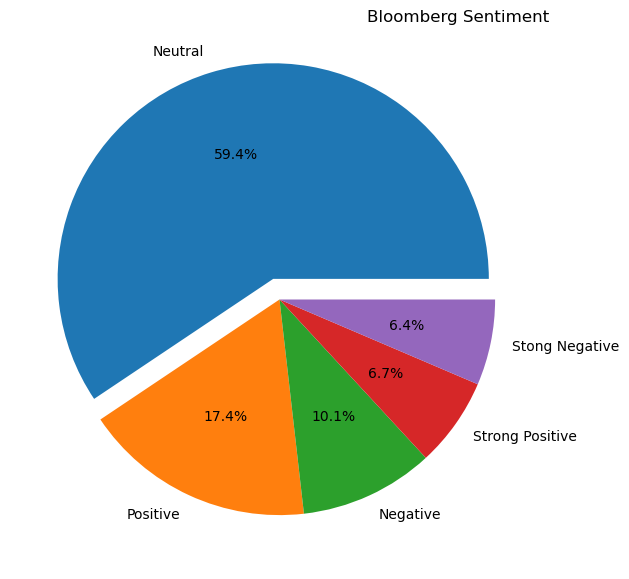

In [28]:
bbg_sentiment_cnt = bbg_tweet['Res'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(bbg_sentiment_cnt.values, labels = bbg_sentiment_cnt.index, explode = (0.1, 0, 0, 0, 0), autopct='%1.1f%%', shadow=False)
plt.title('Bloomberg Sentiment', loc='right');

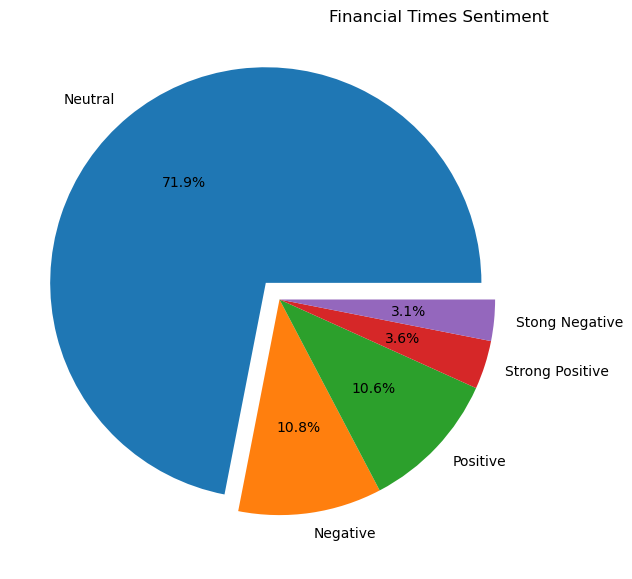

In [29]:
ft_sentiment_cnt = ft_tweet['Res'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(ft_sentiment_cnt.values, labels = ft_sentiment_cnt.index, explode = (0.1, 0, 0, 0, 0), autopct='%1.1f%%', shadow=False)
plt.title('Financial Times Sentiment', loc='right');

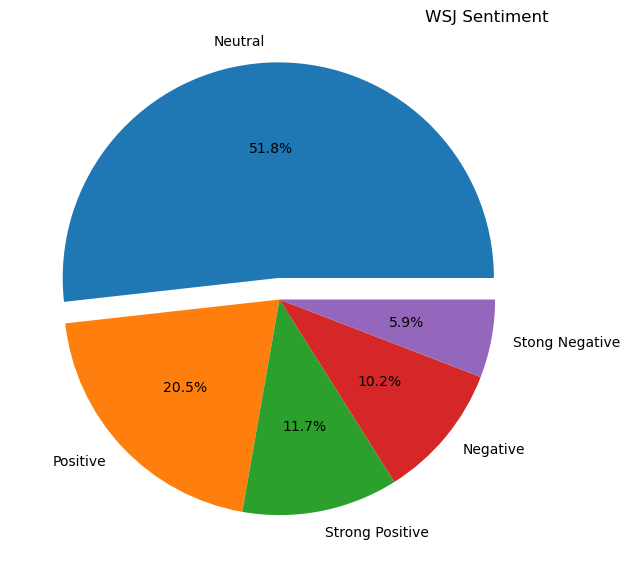

In [30]:
wsj_sentiment_cnt = wsj_tweet['Res'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(wsj_sentiment_cnt.values, labels = wsj_sentiment_cnt.index, explode = (0.1, 0, 0, 0, 0), autopct='%1.1f%%', shadow=False)
plt.title('WSJ Sentiment', loc='right');

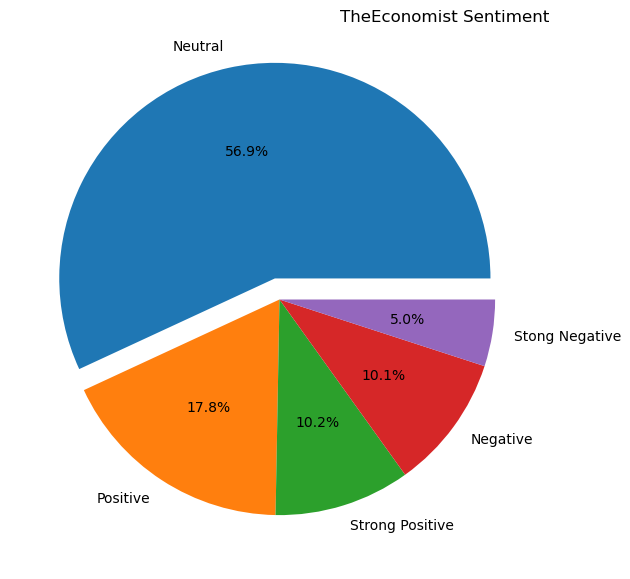

In [31]:
econ_sentiment_cnt = econ_tweet['Res'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(econ_sentiment_cnt.values, labels = econ_sentiment_cnt.index, explode = (0.1, 0, 0, 0, 0), autopct='%1.1f%%', shadow=False)
plt.title('TheEconomist Sentiment', loc='right');

### Sentiment Scores

#### Bloomberg

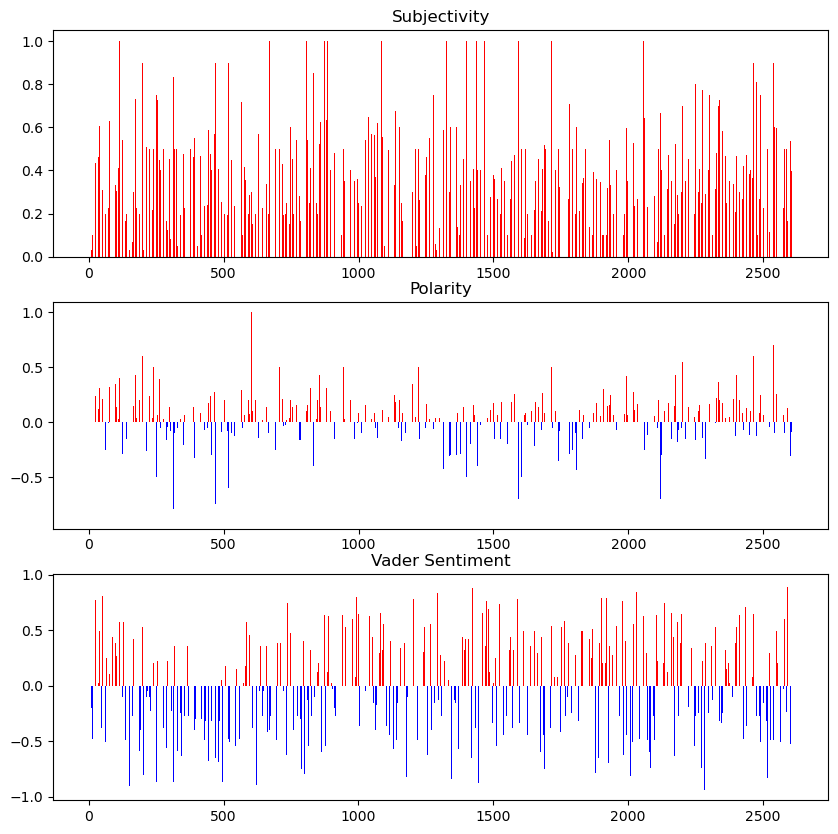

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0.2})
fig.set_figheight(10)
fig.set_figwidth(10)
ax = plt.subplot(111)    # The big subplot
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
ax1.bar(bbg_tweet[bbg_tweet['Subjectivity'] > 0]['Subjectivity'].index, bbg_tweet[bbg_tweet['Subjectivity'] > 0]['Subjectivity'], width = 0.5, color='r')
ax1.bar(bbg_tweet[bbg_tweet['Subjectivity'] < 0]['Subjectivity'].index, bbg_tweet[bbg_tweet['Subjectivity'] < 0]['Subjectivity'], width=0.5, color='b')
ax2.bar(bbg_tweet[bbg_tweet['Polarity'] > 0]['Polarity'].index, bbg_tweet[bbg_tweet['Polarity'] > 0]['Polarity'], width = 0.5, color='r')
ax2.bar(bbg_tweet[bbg_tweet['Polarity'] < 0]['Polarity'].index, bbg_tweet[bbg_tweet['Polarity'] < 0]['Polarity'], width = 0.5, color='b')
ax3.bar(bbg_tweet[bbg_tweet['Vader Sentiment'] > 0]['Vader Sentiment'].index, bbg_tweet[bbg_tweet['Vader Sentiment'] > 0]['Vader Sentiment'], width=0.5, color='r')
ax3.bar(bbg_tweet[bbg_tweet['Vader Sentiment'] < 0]['Vader Sentiment'].index, bbg_tweet[bbg_tweet['Vader Sentiment'] < 0]['Vader Sentiment'], width=0.5, color='b')

# Set common labels
ax.set_xlabel('News')
ax.set_ylabel('Score')

ax1.set_title('Subjectivity')
ax2.set_title('Polarity')
ax3.set_title('Vader Sentiment')

plt.savefig('Sentiment Scores for Bloomberg News.png', dpi=300);

#### FT

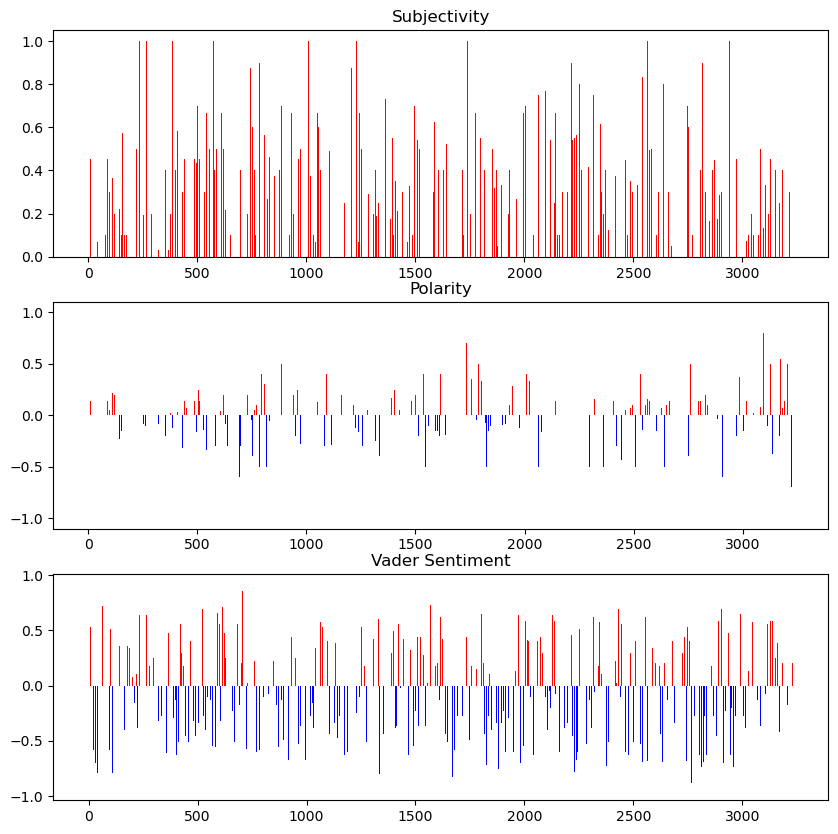

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0.2})
fig.set_figheight(10)
fig.set_figwidth(10)
ax = plt.subplot(111)    # The big subplot
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
ax1.bar(ft_tweet[ft_tweet['Subjectivity'] > 0]['Subjectivity'].index, ft_tweet[ft_tweet['Subjectivity'] > 0]['Subjectivity'], width = 0.5, color='r')
ax1.bar(ft_tweet[ft_tweet['Subjectivity'] < 0]['Subjectivity'].index, ft_tweet[ft_tweet['Subjectivity'] < 0]['Subjectivity'], width=0.5, color='b')
ax2.bar(ft_tweet[ft_tweet['Polarity'] > 0]['Polarity'].index, ft_tweet[ft_tweet['Polarity'] > 0]['Polarity'], width = 0.5, color='r')
ax2.bar(ft_tweet[ft_tweet['Polarity'] < 0]['Polarity'].index, ft_tweet[ft_tweet['Polarity'] < 0]['Polarity'], width = 0.5, color='b')
ax3.bar(ft_tweet[ft_tweet['Vader Sentiment'] > 0]['Vader Sentiment'].index, ft_tweet[ft_tweet['Vader Sentiment'] > 0]['Vader Sentiment'], width=0.5, color='r')
ax3.bar(ft_tweet[ft_tweet['Vader Sentiment'] < 0]['Vader Sentiment'].index, ft_tweet[ft_tweet['Vader Sentiment'] < 0]['Vader Sentiment'], width=0.5, color='b')

# Set common labels
ax.set_xlabel('News')
ax.set_ylabel('Score')

ax1.set_title('Subjectivity')
ax2.set_title('Polarity')
ax3.set_title('Vader Sentiment')

plt.savefig('Sentiment Scores for FT News.png', dpi=300);

#### WSJ

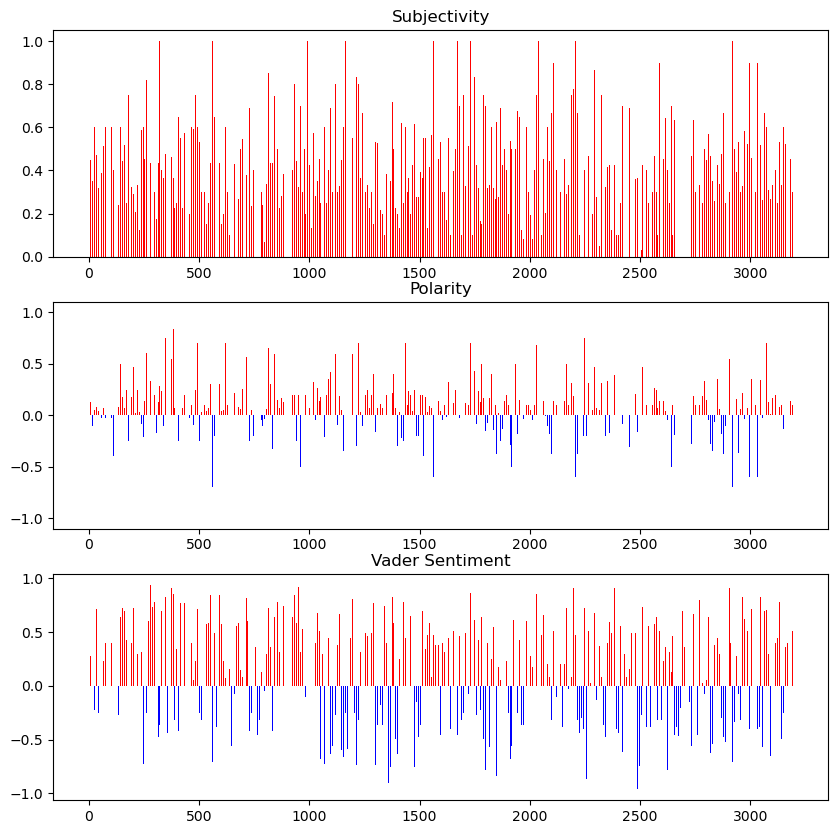

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0.2})
fig.set_figheight(10)
fig.set_figwidth(10)
ax = plt.subplot(111)    # The big subplot
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
ax1.bar(wsj_tweet[wsj_tweet['Subjectivity'] > 0]['Subjectivity'].index, wsj_tweet[wsj_tweet['Subjectivity'] > 0]['Subjectivity'], width = 0.5, color='r')
ax1.bar(wsj_tweet[wsj_tweet['Subjectivity'] < 0]['Subjectivity'].index, wsj_tweet[wsj_tweet['Subjectivity'] < 0]['Subjectivity'], width=0.5, color='b')
ax2.bar(wsj_tweet[wsj_tweet['Polarity'] > 0]['Polarity'].index, wsj_tweet[wsj_tweet['Polarity'] > 0]['Polarity'], width = 0.5, color='r')
ax2.bar(wsj_tweet[wsj_tweet['Polarity'] < 0]['Polarity'].index, wsj_tweet[wsj_tweet['Polarity'] < 0]['Polarity'], width = 0.5, color='b')
ax3.bar(wsj_tweet[wsj_tweet['Vader Sentiment'] > 0]['Vader Sentiment'].index, wsj_tweet[wsj_tweet['Vader Sentiment'] > 0]['Vader Sentiment'], width=0.5, color='r')
ax3.bar(wsj_tweet[wsj_tweet['Vader Sentiment'] < 0]['Vader Sentiment'].index, wsj_tweet[wsj_tweet['Vader Sentiment'] < 0]['Vader Sentiment'], width=0.5, color='b')

# Set common labels
ax.set_xlabel('News')
ax.set_ylabel('Score')

ax1.set_title('Subjectivity')
ax2.set_title('Polarity')
ax3.set_title('Vader Sentiment')

plt.savefig('Sentiment Scores for WSJ News.png', dpi=300);

#### TheEconomist

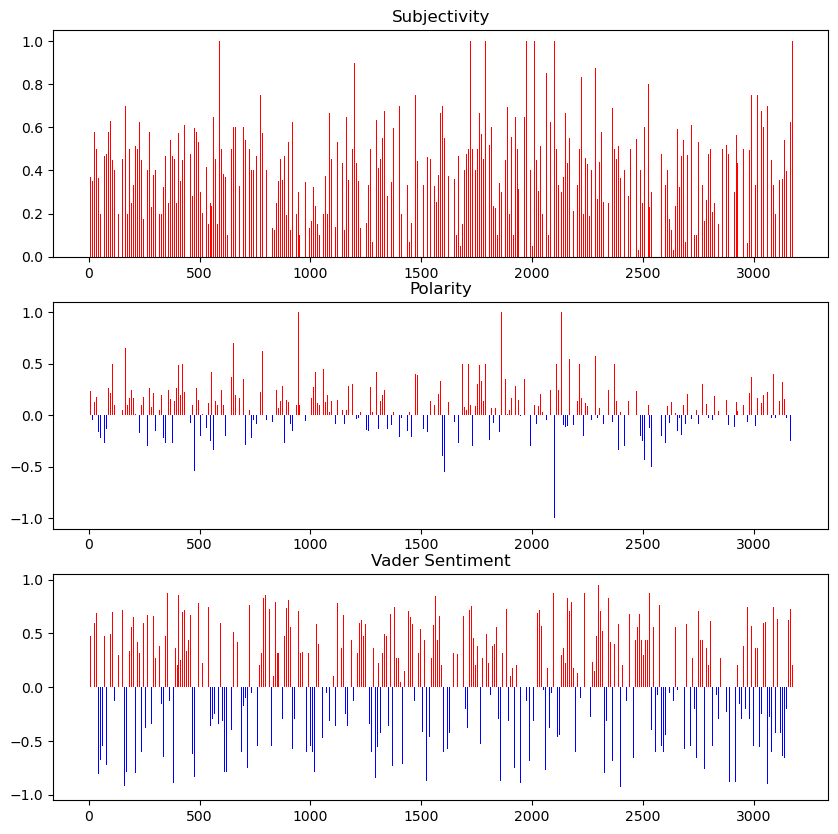

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0.2})
fig.set_figheight(10)
fig.set_figwidth(10)
ax = plt.subplot(111)    # The big subplot
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
ax1.bar(econ_tweet[econ_tweet['Subjectivity'] > 0]['Subjectivity'].index, econ_tweet[econ_tweet['Subjectivity'] > 0]['Subjectivity'], width = 0.5, color='r')
ax1.bar(econ_tweet[econ_tweet['Subjectivity'] < 0]['Subjectivity'].index, econ_tweet[econ_tweet['Subjectivity'] < 0]['Subjectivity'], width=0.5, color='b')
ax2.bar(econ_tweet[econ_tweet['Polarity'] > 0]['Polarity'].index, econ_tweet[econ_tweet['Polarity'] > 0]['Polarity'], width = 0.5, color='r')
ax2.bar(econ_tweet[econ_tweet['Polarity'] < 0]['Polarity'].index, econ_tweet[econ_tweet['Polarity'] < 0]['Polarity'], width = 0.5, color='b')
ax3.bar(econ_tweet[econ_tweet['Vader Sentiment'] > 0]['Vader Sentiment'].index, econ_tweet[econ_tweet['Vader Sentiment'] > 0]['Vader Sentiment'], width=0.5, color='r')
ax3.bar(econ_tweet[econ_tweet['Vader Sentiment'] < 0]['Vader Sentiment'].index, econ_tweet[econ_tweet['Vader Sentiment'] < 0]['Vader Sentiment'], width=0.5, color='b')

# Set common labels
ax.set_xlabel('News')
ax.set_ylabel('Score')

ax1.set_title('Subjectivity')
ax2.set_title('Polarity')
ax3.set_title('Vader Sentiment')

plt.savefig('Sentiment Scores for TheEconomist News.png', dpi=300);

### Time series chart of rolling 5 period mean of Vader Sentiment

In [36]:
# Bloomberg
vader_rolling_df_bbg = pd.DataFrame({'Vader Sentiment': bbg_tweet['Vader Sentiment'], 'PublishedAt': bbg_tweet['Date Created']})

new_format = "%Y-%m-%d"
for i in range(len(vader_rolling_df_bbg)):
    vader_rolling_df_bbg['PublishedAt'][i] = datetime.strptime(vader_rolling_df_bbg['PublishedAt'][i][:-6], "%Y-%m-%d %H:%M:%S")  # "%Y-%m-%dT%H:%M:%SZ"
    vader_rolling_df_bbg['PublishedAt'][i] = vader_rolling_df_bbg['PublishedAt'][i].strftime(new_format)

vader_rolling_df_bbg = vader_rolling_df_bbg.sort_values('PublishedAt').reset_index(drop=True)

vader_rolling_group_bbg = vader_rolling_df_bbg.groupby('PublishedAt')['Vader Sentiment'].sum().rolling(5).mean()
vader_rolling_group_df_bbg = pd.DataFrame({'PublishedAt':vader_rolling_group_bbg.index, 'Rolling Mean Score':vader_rolling_group_bbg.values})

vader_rolling_plot_bbg = vader_rolling_df_bbg.groupby('PublishedAt')['Vader Sentiment'].sum()
vader_rolling_plot_df_bbg = pd.DataFrame({'PublishedAt':vader_rolling_plot_bbg.index, 'Daily Score':vader_rolling_plot_bbg.values})


# FT
vader_rolling_df_ft = pd.DataFrame({'Vader Sentiment': ft_tweet['Vader Sentiment'], 'PublishedAt': ft_tweet['Date Created']})

new_format = "%Y-%m-%d"
for i in range(len(vader_rolling_df_ft)):
    vader_rolling_df_ft['PublishedAt'][i] = datetime.strptime(vader_rolling_df_ft['PublishedAt'][i][:-6], "%Y-%m-%d %H:%M:%S")  # "%Y-%m-%dT%H:%M:%SZ"
    vader_rolling_df_ft['PublishedAt'][i] = vader_rolling_df_ft['PublishedAt'][i].strftime(new_format)

vader_rolling_df_ft = vader_rolling_df_ft.sort_values('PublishedAt').reset_index(drop=True)

vader_rolling_group_ft = vader_rolling_df_ft.groupby('PublishedAt')['Vader Sentiment'].sum().rolling(5).mean()
vader_rolling_group_df_ft = pd.DataFrame({'PublishedAt':vader_rolling_group_ft.index, 'Rolling Mean Score':vader_rolling_group_ft.values})

vader_rolling_plot_ft = vader_rolling_df_ft.groupby('PublishedAt')['Vader Sentiment'].sum()
vader_rolling_plot_df_ft = pd.DataFrame({'PublishedAt':vader_rolling_plot_ft.index, 'Daily Score':vader_rolling_plot_ft.values})


# WSJ
vader_rolling_df_wsj = pd.DataFrame({'Vader Sentiment': wsj_tweet['Vader Sentiment'], 'PublishedAt': wsj_tweet['Date Created']})

new_format = "%Y-%m-%d"
for i in range(len(vader_rolling_df_wsj)):
    vader_rolling_df_wsj['PublishedAt'][i] = datetime.strptime(vader_rolling_df_wsj['PublishedAt'][i][:-6], "%Y-%m-%d %H:%M:%S")  # "%Y-%m-%dT%H:%M:%SZ"
    vader_rolling_df_wsj['PublishedAt'][i] = vader_rolling_df_wsj['PublishedAt'][i].strftime(new_format)

vader_rolling_df_wsj = vader_rolling_df_wsj.sort_values('PublishedAt').reset_index(drop=True)

vader_rolling_group_wsj = vader_rolling_df_wsj.groupby('PublishedAt')['Vader Sentiment'].sum().rolling(5).mean()
vader_rolling_group_df_wsj = pd.DataFrame({'PublishedAt':vader_rolling_group_wsj.index, 'Rolling Mean Score':vader_rolling_group_wsj.values})

vader_rolling_plot_wsj = vader_rolling_df_wsj.groupby('PublishedAt')['Vader Sentiment'].sum()
vader_rolling_plot_df_wsj = pd.DataFrame({'PublishedAt':vader_rolling_plot_wsj.index, 'Daily Score':vader_rolling_plot_wsj.values})


# TheEconomist
vader_rolling_df_econ = pd.DataFrame({'Vader Sentiment': econ_tweet['Vader Sentiment'], 'PublishedAt': econ_tweet['Date Created']})

new_format = "%Y-%m-%d"
for i in range(len(vader_rolling_df_econ)):
    vader_rolling_df_econ['PublishedAt'][i] = datetime.strptime(vader_rolling_df_econ['PublishedAt'][i][:-6], "%Y-%m-%d %H:%M:%S")  # "%Y-%m-%dT%H:%M:%SZ"
    vader_rolling_df_econ['PublishedAt'][i] = vader_rolling_df_econ['PublishedAt'][i].strftime(new_format)

vader_rolling_df_econ = vader_rolling_df_econ.sort_values('PublishedAt').reset_index(drop=True)

vader_rolling_group_econ = vader_rolling_df_econ.groupby('PublishedAt')['Vader Sentiment'].sum().rolling(5).mean()
vader_rolling_group_df_econ = pd.DataFrame({'PublishedAt':vader_rolling_group_econ.index, 'Rolling Mean Score':vader_rolling_group_econ.values})

vader_rolling_plot_econ = vader_rolling_df_econ.groupby('PublishedAt')['Vader Sentiment'].sum()
vader_rolling_plot_df_econ = pd.DataFrame({'PublishedAt':vader_rolling_plot_econ.index, 'Daily Score':vader_rolling_plot_econ.values})

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\774201124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_rolling_df_bbg['PublishedAt'][i] = datetime.strptime(vader_rolling_df_bbg['PublishedAt'][i][:-6], "%Y-%m-%d %H:%M:%S")  # "%Y-%m-%dT%H:%M:%SZ"
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\774201124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_rolling_df_bbg['PublishedAt'][i] = vader_rolling_df_bbg['PublishedAt'][i].strftime(new_format)
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\774201124.py:23: SettingWithCopyWarning: 
A value is trying to be set on a 

In [ ]:
from functools import reduce
data_frames = [vader_rolling_plot_df_bbg, vader_rolling_plot_df_ft, vader_rolling_plot_df_wsj, vader_rolling_plot_df_econ]
rolling_plot_merged = reduce(lambda  left,right: pd.merge(left,right,on=['PublishedAt'], how='outer'), data_frames)

data_frames = [vader_rolling_group_df_bbg, vader_rolling_group_df_ft, vader_rolling_group_df_wsj, vader_rolling_group_df_econ]
rolling_group_merged = reduce(lambda  left,right: pd.merge(left,right,on=['PublishedAt'], how='outer'), data_frames)

In [ ]:
rolling_plot_merged = rolling_plot_merged.sort_values(['PublishedAt']).reset_index(drop=True)
rolling_group_merged = rolling_group_merged.sort_values(['PublishedAt']).reset_index(drop=True)
rolling_plot_merged = rolling_plot_merged.set_axis(['PublishedAt', 'Daily_Score_BBG', 'Daily_Score_FT', 'Daily_Score_WSJ', 'Daily_Score_Econ'], axis=1)
rolling_group_merged = rolling_group_merged.set_axis(['PublishedAt', 'Rolling_Mean_Score_BBG', 'Rolling_Mean_Score_FT', 'Rolling_Mean_Score_WSJ', 'Rolling_Mean_Score_Econ'], axis=1)

In [ ]:
rolling_plot_merged['Daily_Score_BBG'] = rolling_plot_merged['Daily_Score_BBG'].fillna(0)
rolling_plot_merged['Daily_Score_FT'] = rolling_plot_merged['Daily_Score_FT'].fillna(0)
rolling_plot_merged['Daily_Score_WSJ'] = rolling_plot_merged['Daily_Score_WSJ'].fillna(0)
rolling_plot_merged['Daily_Score_Econ'] = rolling_plot_merged['Daily_Score_Econ'].fillna(0)

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\3230962288.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(rolling_plot_merged['PublishedAt'], rotation=60)
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\3230962288.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(rolling_plot_merged['PublishedAt'], rotation=60)
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\3230962288.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(rolling_plot_merged['PublishedAt'], rotation=60)
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\3230962288.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(rolling_plot_merged['PublishedAt'], rotation=60)


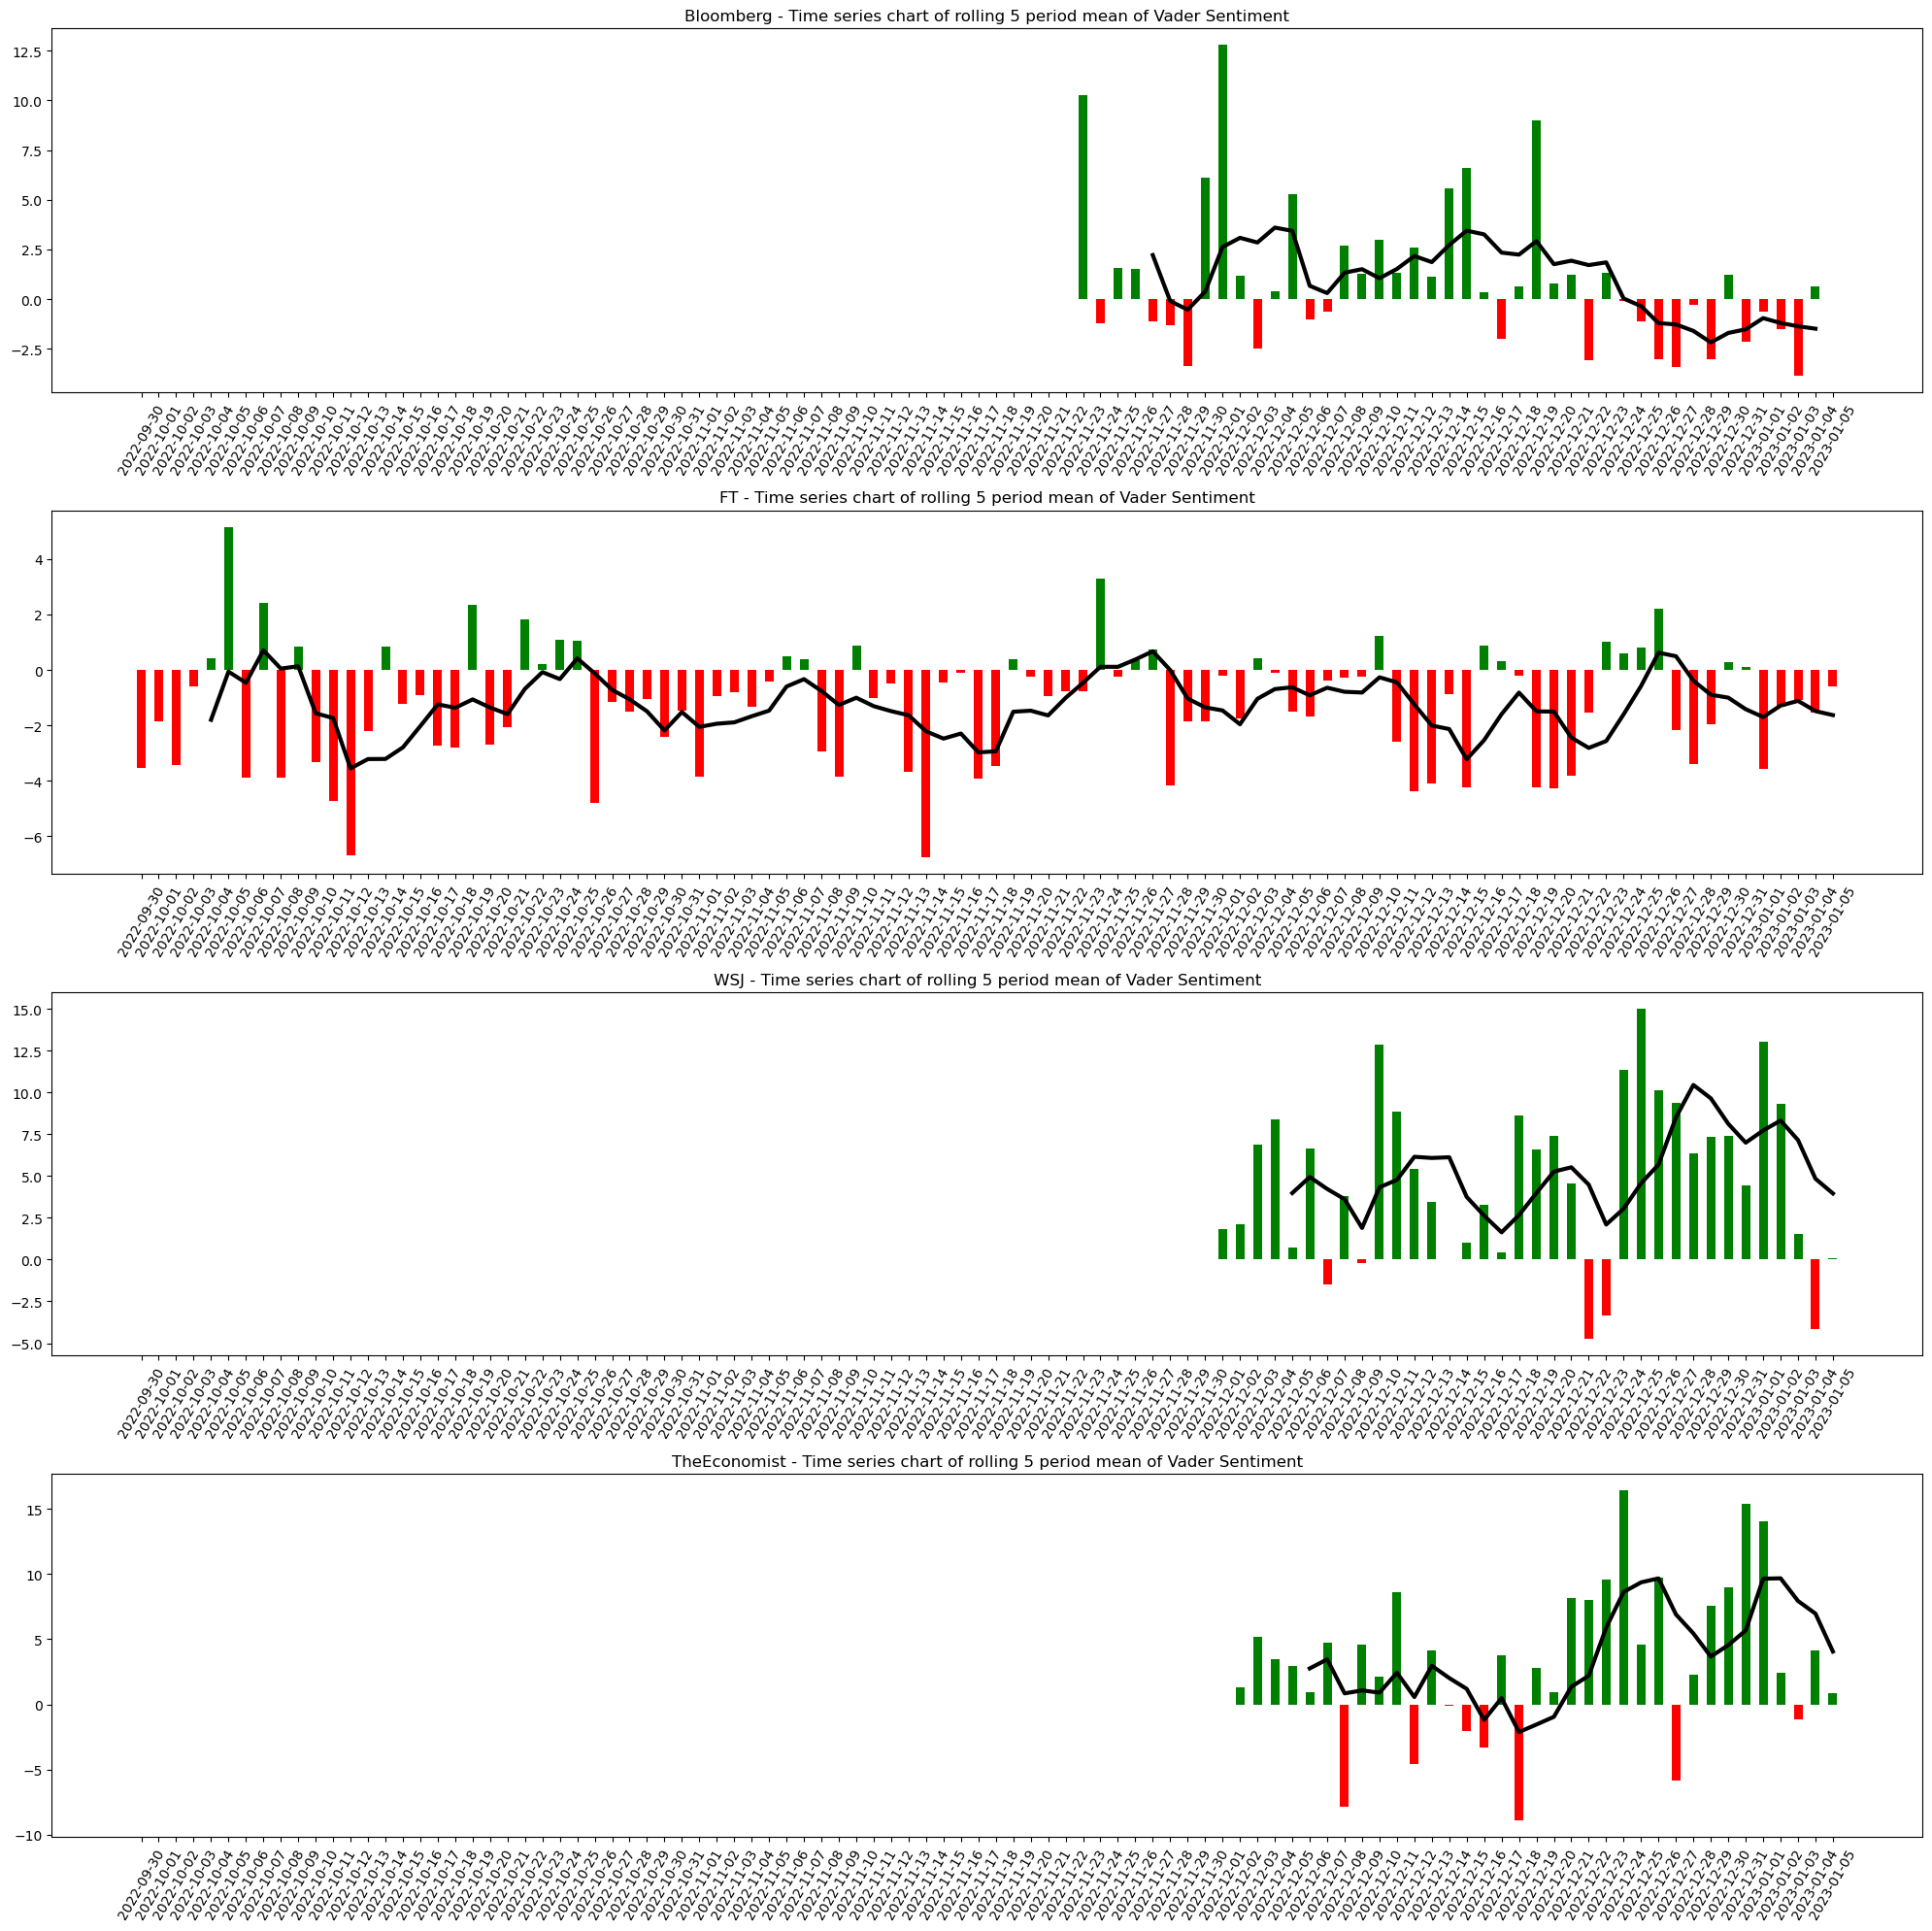

In [83]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex='all', gridspec_kw={'hspace': 0.2})
fig.set_figheight(20)
fig.set_figwidth(20)
ax = plt.subplot(111)    # The big subplot
ax1 = plt.subplot(411)
ax2 = plt.subplot(412)
ax3 = plt.subplot(413)
ax4 = plt.subplot(414)

ax1.plot(rolling_group_merged['PublishedAt'], rolling_group_merged['Rolling_Mean_Score_BBG'], linewidth=3, color='black')
ax2.plot(rolling_group_merged['PublishedAt'], rolling_group_merged['Rolling_Mean_Score_FT'], linewidth=3, color='black')
ax3.plot(rolling_group_merged['PublishedAt'], rolling_group_merged['Rolling_Mean_Score_WSJ'], linewidth=3, color='black')
ax4.plot(rolling_group_merged['PublishedAt'], rolling_group_merged['Rolling_Mean_Score_Econ'], linewidth=3, color='black')

colormat=np.where(rolling_plot_merged['Daily_Score_BBG']>0, 'g','r')
ax1.bar(rolling_plot_merged['PublishedAt'], rolling_plot_merged['Daily_Score_BBG'], width=0.5, color=colormat)

colormat=np.where(rolling_plot_merged['Daily_Score_FT']>0, 'g','r')
ax2.bar(rolling_plot_merged['PublishedAt'], rolling_plot_merged['Daily_Score_FT'], width=0.5, color=colormat)

colormat=np.where(rolling_plot_merged['Daily_Score_WSJ']>0, 'g','r')
ax3.bar(rolling_plot_merged['PublishedAt'], rolling_plot_merged['Daily_Score_WSJ'], width=0.5, color=colormat)

colormat=np.where(rolling_plot_merged['Daily_Score_Econ']>0, 'g','r')
ax4.bar(rolling_plot_merged['PublishedAt'], rolling_plot_merged['Daily_Score_Econ'], width=0.5, color=colormat)

# Set common labels
ax.set_xlabel('Published Date')
ax.set_ylabel('Score')

ax1.set_title('Bloomberg - Time series chart of rolling 5 period mean of Vader Sentiment')
ax2.set_title('FT - Time series chart of rolling 5 period mean of Vader Sentiment')
ax3.set_title('WSJ - Time series chart of rolling 5 period mean of Vader Sentiment')
ax4.set_title('TheEconomist - Time series chart of rolling 5 period mean of Vader Sentiment')

ax1.set_xticklabels(rolling_plot_merged['PublishedAt'], rotation=60)
ax2.set_xticklabels(rolling_plot_merged['PublishedAt'], rotation=60)
ax3.set_xticklabels(rolling_plot_merged['PublishedAt'], rotation=60)
ax4.set_xticklabels(rolling_plot_merged['PublishedAt'], rotation=60)

fig.tight_layout()
plt.savefig('Sentiment Scores for Four Account.png', dpi=300);

Based on the above result, we can find that the sentiment from FT is quite different from other accounts. One reason I've thought about is because the number of articles from the account is relatively small. As a result, any negative articles or even words would have larger impact on our evaluation. Another reason is different journals have different focus area. For example, the WSJ is more of an American paper, the FT is a British paper, and TheEconomist is more a European paper. FT sees itself as an international elite paper that happens to be based in London. So based on the economic condition in the UK, the sentiment is less optimistic compared to the US. Another pattern we can find in the chart is the fact that Bloomberg, WSJ, and TheEconomist have a obvious downward trend recently. The fear of inflation, hawkish monetary policy, and hard-landing cover the US market, as we can see the technology sector slumps a lot.

### % of tweets mentioning “Inflation” per Month 

#### BBG

In [43]:
jan_cnt = 0
inf_jan_cnt = 0
dec_cnt = 0
inf_dec_cnt = 0
nov_cnt = 0
inf_nov_cnt = 0
for i in range(len(bbg_tweet)):
    if bbg_tweet['Date Created'].iloc[i][5:7] == '01':
        jan_cnt += 1
        if 'inflation' in bbg_tweet['Tweet'].iloc[i]:
            inf_jan_cnt += 1
    if bbg_tweet['Date Created'].iloc[i][5:7] == '12':
        dec_cnt += 1
        if 'inflation' in bbg_tweet['Tweet'].iloc[i]:
            inf_dec_cnt += 1
    if bbg_tweet['Date Created'].iloc[i][5:7] == '11':
        nov_cnt += 1
        if 'inflation' in bbg_tweet['Tweet'].iloc[i]:
            inf_nov_cnt += 1

In [44]:
bbg_inflation_ratio = pd.DataFrame({'Jan':[round(inf_jan_cnt/jan_cnt*100, 2)], 'Dec':[round(inf_dec_cnt/dec_cnt*100, 2)], 'Nov':[round(inf_nov_cnt/nov_cnt*100, 2)]})
bbg_inflation_ratio.index = ['% of tweets related to inflation']
bbg_inflation_ratio

,Jan,Dec,Nov
% of tweets related to inflation,8.12,6.06,6.63


#### FT

In [45]:
jan_cnt = 0
inf_jan_cnt = 0
dec_cnt = 0
inf_dec_cnt = 0
nov_cnt = 0
inf_nov_cnt = 0
oct_cnt = 0
inf_oct_cnt = 0
sep_cnt = 0
inf_sep_cnt = 0

for i in range(len(ft_tweet)):
    if ft_tweet['Date Created'].iloc[i][5:7] == '01':
        jan_cnt += 1
        if 'inflation' in ft_tweet['Tweet'].iloc[i]:
            inf_jan_cnt += 1
    if ft_tweet['Date Created'].iloc[i][5:7] == '12':
        dec_cnt += 1
        if 'inflation' in ft_tweet['Tweet'].iloc[i]:
            inf_dec_cnt += 1
    if ft_tweet['Date Created'].iloc[i][5:7] == '11':
        nov_cnt += 1
        if 'inflation' in ft_tweet['Tweet'].iloc[i]:
            inf_nov_cnt += 1
    if ft_tweet['Date Created'].iloc[i][5:7] == '10':
        oct_cnt += 1
        if 'inflation' in ft_tweet['Tweet'].iloc[i]:
            inf_oct_cnt += 1
    if ft_tweet['Date Created'].iloc[i][5:7] == '09':
        sep_cnt += 1
        if 'inflation' in ft_tweet['Tweet'].iloc[i]:
            inf_sep_cnt += 1

In [46]:
ft_inflation_ratio = pd.DataFrame({'Jan':[round(inf_jan_cnt/jan_cnt*100, 2)], 'Dec':[round(inf_dec_cnt/dec_cnt*100, 2)], 'Nov':[round(inf_nov_cnt/nov_cnt*100, 2)], 'Oct':[round(inf_oct_cnt/oct_cnt*100, 2)], 'Sep':[round(inf_sep_cnt/sep_cnt*100, 2)]})
ft_inflation_ratio.index = ['% of tweets related to inflation']
ft_inflation_ratio

,Jan,Dec,Nov,Oct,Sep
% of tweets related to inflation,6.36,1.99,1.88,1.31,2.86


#### WSJ

In [47]:
jan_cnt = 0
inf_jan_cnt = 0
dec_cnt = 0
inf_dec_cnt = 0
for i in range(len(wsj_tweet)):
    if wsj_tweet['Date Created'].iloc[i][5:7] == '01':
        jan_cnt += 1
        if 'inflation' in wsj_tweet['Tweet'].iloc[i]:
            inf_jan_cnt += 1
    if wsj_tweet['Date Created'].iloc[i][5:7] == '12':
        dec_cnt += 1
        if 'inflation' in wsj_tweet['Tweet'].iloc[i]:
            inf_dec_cnt += 1

In [48]:
wsj_inflation_ratio = pd.DataFrame({'Jan':[round(inf_jan_cnt/jan_cnt*100, 2)], 'Dec':[round(inf_dec_cnt/dec_cnt*100, 2)]})
wsj_inflation_ratio.index = ['% of tweets related to inflation']
wsj_inflation_ratio

,Jan,Dec
% of tweets related to inflation,1.62,1.95


#### TheEconomist

In [49]:
jan_cnt = 0
inf_jan_cnt = 0
dec_cnt = 0
inf_dec_cnt = 0
for i in range(len(econ_tweet)):
    if econ_tweet['Date Created'].iloc[i][5:7] == '01':
        jan_cnt += 1
        if 'inflation' in econ_tweet['Tweet'].iloc[i]:
            inf_jan_cnt += 1
    if econ_tweet['Date Created'].iloc[i][5:7] == '12':
        dec_cnt += 1
        if 'inflation' in econ_tweet['Tweet'].iloc[i]:
            inf_dec_cnt += 1

In [50]:
econ_inflation_ratio = pd.DataFrame({'Jan':[round(inf_jan_cnt/jan_cnt*100, 2)], 'Dec':[round(inf_dec_cnt/dec_cnt*100, 2)]})
econ_inflation_ratio.index = ['% of tweets related to inflation']
econ_inflation_ratio

,Jan,Dec
% of tweets related to inflation,2.95,2.44


In [51]:
arrays = [
    ["Bloomberg", "Bloomberg", "Bloomberg", "FT", "FT", "FT", "FT", "FT", "WSJ", "WSJ", "Econ", "Econ"],
    ["Jan", "Dec", "Nov", "Jan", "Dec", "Nov", "Oct", "Sep", "Jan", "Dec", "Jan", "Dec"],
]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=["Account", "Month"])
ratio = pd.Series([bbg_inflation_ratio.values[0][0], bbg_inflation_ratio.values[0][1], bbg_inflation_ratio.values[0][2], ft_inflation_ratio.values[0][0], ft_inflation_ratio.values[0][1], ft_inflation_ratio.values[0][2], ft_inflation_ratio.values[0][3], ft_inflation_ratio.values[0][4], wsj_inflation_ratio.values[0][0], wsj_inflation_ratio.values[0][1], econ_inflation_ratio.values[0][0], econ_inflation_ratio.values[0][1]], index=index)
ratio = ratio.to_frame()
ratio.rename({0:'% of tweets'}, axis=1)

% of tweets
Account   Month             
Bloomberg Jan           8.12
          Dec           6.06
          Nov           6.63
FT        Jan           6.36
          Dec           1.99
          Nov           1.88
          Oct           1.31
          Sep           2.86
WSJ       Jan           1.62
          Dec           1.95
Econ      Jan           2.95
          Dec           2.44

## Daily Report

In [ ]:
import tweepy
 
# API keyws that yous saved earlier
api_key = 'YOUR API KEY'
api_secret_key = "YOUR API SECRET KEY"
access_token = 'YOUR ACCESS TOKEN'
access_token_secret = 'YOUR ACCESS TOKEN SECRET'
bearer_token = 'YOU BEARER TOKEN'

# Authenticate to Twitter
auth = tweepy.OAuthHandler(api_key,api_secret_key)
auth.set_access_token(access_token,access_token_secret)

api = tweepy.API(auth)
 
try:
    api.verify_credentials()
    print('Successful Authentication')
except:
    print('Failed authentication')

In [110]:
import csv
import os
import re
from re import sub
import tweepy
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
from tkinter import *
import base64
from tkinter import messagebox
import tkinter.font as font
import tk
import snscrape.modules.twitter as sntwitter
import matplotlib.pyplot as plt
import pickle
import nltk
import logging
import multiprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from time import time 
from unidecode import unidecode
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet
import spacy 
import stanza 
import spacy_stanza
from negspacy.negation import Negex
from negspacy.termsets import termset
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn

[nltk_data] Downloading package punkt to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to C:\Users\TMF Jagon
[nltk_data]     Chou\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [109]:
now = datetime.today().now()
prev=now-timedelta(days=1)
now=now.strftime("%Y-%m-%d %H:%M:%S")
prev=prev.strftime("%Y-%m-%d %H:%M:%S")
now=datetime.strptime(now, '%Y-%m-%d %H:%M:%S')
prev=datetime.strptime(prev, '%Y-%m-%d %H:%M:%S')

#### Bloomberg
columns = ["Date Created", "Tweet", 'label']
bbg_df = pd.DataFrame(columns=columns)
date_created = []
tweets = []
username = "markets"
#2023-01-05 00:45:04+00:00
for tweet in tweepy.Cursor(api.user_timeline, screen_name=username, tweet_mode='extended').items():
    created_at = tweet.created_at.strftime("%Y-%m-%d %H:%M:%S+00:00")
    created_at = datetime.strptime(created_at[:-6], '%Y-%m-%d %H:%M:%S')
    if created_at < prev:
        break
    if 'RT' in tweet.full_text:
        continue
    date_created.append(created_at)
    tweets.append(tweet.full_text)

bbg_df['Date Created'] = date_created
bbg_df['Tweet'] = tweets
bbg_df['label'] = ['BBG']*len(bbg_df)
bbg_df.to_csv('bloomberg_data_daily.csv', index=False, header=True)


#### FT
columns = ["Date Created", "Tweet", 'label']
FT_df = pd.DataFrame(columns=columns)
date_created = []
tweets = []
username = "FT"

for tweet in tweepy.Cursor(api.user_timeline, screen_name=username, tweet_mode='extended').items():
    created_at = tweet.created_at.strftime("%Y-%m-%d %H:%M:%S+00:00")
    created_at = datetime.strptime(created_at[:-6], '%Y-%m-%d %H:%M:%S')
    if created_at < prev:
        break
    if 'RT' in tweet.full_text:
        continue
    date_created.append(created_at)
    tweets.append(tweet.full_text)

FT_df['Date Created'] = date_created
FT_df['Tweet'] = tweets
FT_df['label'] = ['FT']*len(FT_df)
FT_df.to_csv('FT_data_daily.csv', index=False, header=True)


#### WSJ
columns = ["Date Created", "Tweet", 'label']
WSJ_df = pd.DataFrame(columns=columns)
date_created = []
tweets = []
username = "WSJ"

for tweet in tweepy.Cursor(api.user_timeline, screen_name=username, tweet_mode='extended').items():
    created_at = tweet.created_at.strftime("%Y-%m-%d %H:%M:%S+00:00")
    created_at = datetime.strptime(created_at[:-6], '%Y-%m-%d %H:%M:%S')
    if created_at < prev:
        break
    if 'RT' in tweet.full_text:
        continue
    date_created.append(created_at)
    tweets.append(tweet.full_text)

WSJ_df['Date Created'] = date_created
WSJ_df['Tweet'] = tweets
WSJ_df['label'] = ['WSJ']*len(WSJ_df)
WSJ_df.to_csv('WSJ_data_daily.csv', index=False, header=True)


# TheEconomist
columns = ["Date Created", "Tweet", 'label']
econ_df = pd.DataFrame(columns=columns)
date_created = []
tweets = []
username = "TheEconomist"

for tweet in tweepy.Cursor(api.user_timeline, screen_name=username, tweet_mode='extended').items():
    created_at = tweet.created_at.strftime("%Y-%m-%d %H:%M:%S+00:00")
    created_at = datetime.strptime(created_at[:-6], '%Y-%m-%d %H:%M:%S')
    if created_at < prev:
        break
    if 'RT' in tweet.full_text:
        continue
    date_created.append(created_at)
    tweets.append(tweet.full_text)

econ_df['Date Created'] = date_created
econ_df['Tweet'] = tweets
econ_df['label'] = ['Econ']*len(econ_df)
econ_df.to_csv('Econ_data_daily.csv', index=False, header=True)

In [111]:
#### Combine Tweets & Data Wrangling
tweets = pd.concat([bbg_df, FT_df, WSJ_df, econ_df], ignore_index=True)
tweets = tweets.sort_values('Date Created', ascending=False)
tweets = tweets.reset_index(drop=True)

sep = ' https'
for i in range(len(tweets)):
    tweets['Tweet'][i] = tweets['Tweet'][i].split(sep, 1)[0]
    
tweets.to_csv('tweets_daily.csv', index=False, header=True)

tweets = pd.read_csv('tweets_daily.csv')


# Define a function to clean the text
def text_to_word_list(text):
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)

    return text

# Cleaning the text in the column
tweets['Tweet'] = tweets['Tweet'].apply(text_to_word_list)


### Split into 4 sources
bbg_tweet = tweets[tweets['label'] == 'BBG'].reset_index(drop=True)
ft_tweet = tweets[tweets['label'] == 'FT'].reset_index(drop=True)
wsj_tweet = tweets[tweets['label'] == 'WSJ'].reset_index(drop=True)
econ_tweet = tweets[tweets['label'] == 'Econ'].reset_index(drop=True)

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\1808922174.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['Tweet'][i] = tweets['Tweet'][i].split(sep, 1)[0]


In [112]:
# Tokenization, Stopwords Removal, POS Tagging
def token_stop_pos(text):
    pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist


# Obtaining the stem words – Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew


# TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

## VADER
# function to calculate vader sentiment
def vadersentimentanalysis(review):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(review)
    return vs['compound']

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
        

# SentiWordNet
def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
    if not tokens_count:
        return 0
    if sentiment>0:
        return "Positive"
    if sentiment==0:
        return "Neutral"
    else:
        return "Negative"

In [113]:
bbg_tweet['POS tagged'] = bbg_tweet['Tweet'].apply(token_stop_pos)
bbg_tweet['Lemma'] = bbg_tweet['POS tagged'].apply(lemmatize)
bbg_tweet['Subjectivity'] = bbg_tweet['Lemma'].apply(getSubjectivity) 
bbg_tweet['Polarity'] = bbg_tweet['Lemma'].apply(getPolarity) 
bbg_tweet['TextBlob Analysis'] = bbg_tweet['Polarity'].apply(analysis)

bbg_tweet['Vader Sentiment'] = bbg_tweet['Lemma'].apply(vadersentimentanalysis)
bbg_tweet['Vader Analysis'] = bbg_tweet['Vader Sentiment'].apply(vader_analysis)

bbg_tweet['SWN Analysis'] = bbg_tweet['POS tagged'].apply(sentiwordnetanalysis)

# Selection - Vote
for i in range(len(bbg_tweet)):
    if bbg_tweet['TextBlob Analysis'].iloc[i] == 'Positive':
        bbg_tweet['TextBlob Analysis'].iloc[i] = 1
    elif bbg_tweet['TextBlob Analysis'].iloc[i] == 'Negative':
        bbg_tweet['TextBlob Analysis'].iloc[i] = -1
    else:
        bbg_tweet['TextBlob Analysis'].iloc[i] = 0

    if bbg_tweet['Vader Analysis'].iloc[i] == 'Positive':
        bbg_tweet['Vader Analysis'].iloc[i] = 1
    elif bbg_tweet['Vader Analysis'].iloc[i] == 'Negative':
        bbg_tweet['Vader Analysis'].iloc[i] = -1
    else:
        bbg_tweet['Vader Analysis'].iloc[i] = 0

    if bbg_tweet['SWN Analysis'].iloc[i] == 'Positive':
        bbg_tweet['SWN Analysis'].iloc[i] = 1
    elif bbg_tweet['SWN Analysis'].iloc[i] == 'Negative':
        bbg_tweet['SWN Analysis'].iloc[i] = -1
    else:
        bbg_tweet['SWN Analysis'].iloc[i] = 0

bbg_tweet['finalSentiment'] = [0] * len(bbg_tweet)
for i in range(len(bbg_tweet)):
    bbg_tweet['finalSentiment'].iloc[i] = bbg_tweet['TextBlob Analysis'].iloc[i] + bbg_tweet['Vader Analysis'].iloc[i] + bbg_tweet['SWN Analysis'].iloc[i]

bbg_tweet['Res'] = bbg_tweet['finalSentiment']
for i in range(len(bbg_tweet)):
    if bbg_tweet['finalSentiment'].iloc[i] == 3:
        bbg_tweet['Res'][i] = 'Strong Positive'
    elif bbg_tweet['finalSentiment'].iloc[i] == 2:
        bbg_tweet['Res'][i] = 'Positive'
    elif (bbg_tweet['finalSentiment'].iloc[i] <= 1) and (bbg_tweet['finalSentiment'].iloc[i] >= -1):
        bbg_tweet['Res'][i] = 'Neutral'
    elif bbg_tweet['finalSentiment'].iloc[i] == -2:
        bbg_tweet['Res'][i] = 'Negative'
    elif bbg_tweet['finalSentiment'].iloc[i] == -3:
        bbg_tweet['Res'][i] = 'Stong Negative'

bbg_tweet.to_csv('bbg_tweet_daily.csv', index=False, header=True)


ft_tweet['POS tagged'] = ft_tweet['Tweet'].apply(token_stop_pos)
ft_tweet['Lemma'] = ft_tweet['POS tagged'].apply(lemmatize)
ft_tweet['Subjectivity'] = ft_tweet['Lemma'].apply(getSubjectivity) 
ft_tweet['Polarity'] = ft_tweet['Lemma'].apply(getPolarity) 
ft_tweet['TextBlob Analysis'] = ft_tweet['Polarity'].apply(analysis)

ft_tweet['Vader Sentiment'] = ft_tweet['Lemma'].apply(vadersentimentanalysis)
ft_tweet['Vader Analysis'] = ft_tweet['Vader Sentiment'].apply(vader_analysis)

ft_tweet['SWN Analysis'] = ft_tweet['POS tagged'].apply(sentiwordnetanalysis)


# Selection - Vote
for i in range(len(ft_tweet)):
    if ft_tweet['TextBlob Analysis'].iloc[i] == 'Positive':
        ft_tweet['TextBlob Analysis'].iloc[i] = 1
    elif ft_tweet['TextBlob Analysis'].iloc[i] == 'Negative':
        ft_tweet['TextBlob Analysis'].iloc[i] = -1
    else:
        ft_tweet['TextBlob Analysis'].iloc[i] = 0

    if ft_tweet['Vader Analysis'].iloc[i] == 'Positive':
        ft_tweet['Vader Analysis'].iloc[i] = 1
    elif ft_tweet['Vader Analysis'].iloc[i] == 'Negative':
        ft_tweet['Vader Analysis'].iloc[i] = -1
    else:
        ft_tweet['Vader Analysis'].iloc[i] = 0

    if ft_tweet['SWN Analysis'].iloc[i] == 'Positive':
        ft_tweet['SWN Analysis'].iloc[i] = 1
    elif ft_tweet['SWN Analysis'].iloc[i] == 'Negative':
        ft_tweet['SWN Analysis'].iloc[i] = -1
    else:
        ft_tweet['SWN Analysis'].iloc[i] = 0

ft_tweet['finalSentiment'] = [0] * len(ft_tweet)
for i in range(len(ft_tweet)):
    ft_tweet['finalSentiment'].iloc[i] = ft_tweet['TextBlob Analysis'].iloc[i] + ft_tweet['Vader Analysis'].iloc[i] + ft_tweet['SWN Analysis'].iloc[i]

ft_tweet['Res'] = ft_tweet['finalSentiment']
for i in range(len(ft_tweet)):
    if ft_tweet['finalSentiment'].iloc[i] == 3:
        ft_tweet['Res'][i] = 'Strong Positive'
    elif ft_tweet['finalSentiment'].iloc[i] == 2:
        ft_tweet['Res'][i] = 'Positive'
    elif (ft_tweet['finalSentiment'].iloc[i] <= 1) and (ft_tweet['finalSentiment'].iloc[i] >= -1):
        ft_tweet['Res'][i] = 'Neutral'
    elif ft_tweet['finalSentiment'].iloc[i] == -2:
        ft_tweet['Res'][i] = 'Negative'
    elif ft_tweet['finalSentiment'].iloc[i] == -3:
        ft_tweet['Res'][i] = 'Stong Negative'

ft_tweet.to_csv('ft_tweet_daily.csv', index=False, header=True)


wsj_tweet['POS tagged'] = wsj_tweet['Tweet'].apply(token_stop_pos)
wsj_tweet['Lemma'] = wsj_tweet['POS tagged'].apply(lemmatize)
wsj_tweet['Subjectivity'] = wsj_tweet['Lemma'].apply(getSubjectivity) 
wsj_tweet['Polarity'] = wsj_tweet['Lemma'].apply(getPolarity) 
wsj_tweet['TextBlob Analysis'] = wsj_tweet['Polarity'].apply(analysis)

wsj_tweet['Vader Sentiment'] = wsj_tweet['Lemma'].apply(vadersentimentanalysis)
wsj_tweet['Vader Analysis'] = wsj_tweet['Vader Sentiment'].apply(vader_analysis)

wsj_tweet['SWN Analysis'] = wsj_tweet['POS tagged'].apply(sentiwordnetanalysis)


# Selection - Vote
for i in range(len(wsj_tweet)):
    if wsj_tweet['TextBlob Analysis'].iloc[i] == 'Positive':
        wsj_tweet['TextBlob Analysis'].iloc[i] = 1
    elif wsj_tweet['TextBlob Analysis'].iloc[i] == 'Negative':
        wsj_tweet['TextBlob Analysis'].iloc[i] = -1
    else:
        wsj_tweet['TextBlob Analysis'].iloc[i] = 0

    if wsj_tweet['Vader Analysis'].iloc[i] == 'Positive':
        wsj_tweet['Vader Analysis'].iloc[i] = 1
    elif wsj_tweet['Vader Analysis'].iloc[i] == 'Negative':
        wsj_tweet['Vader Analysis'].iloc[i] = -1
    else:
        wsj_tweet['Vader Analysis'].iloc[i] = 0

    if wsj_tweet['SWN Analysis'].iloc[i] == 'Positive':
        wsj_tweet['SWN Analysis'].iloc[i] = 1
    elif wsj_tweet['SWN Analysis'].iloc[i] == 'Negative':
        wsj_tweet['SWN Analysis'].iloc[i] = -1
    else:
        wsj_tweet['SWN Analysis'].iloc[i] = 0

wsj_tweet['finalSentiment'] = [0] * len(wsj_tweet)
for i in range(len(wsj_tweet)):
    wsj_tweet['finalSentiment'].iloc[i] = wsj_tweet['TextBlob Analysis'].iloc[i] + wsj_tweet['Vader Analysis'].iloc[i] + wsj_tweet['SWN Analysis'].iloc[i]

wsj_tweet['Res'] = wsj_tweet['finalSentiment']
for i in range(len(wsj_tweet)):
    if wsj_tweet['finalSentiment'].iloc[i] == 3:
        wsj_tweet['Res'][i] = 'Strong Positive'
    elif wsj_tweet['finalSentiment'].iloc[i] == 2:
        wsj_tweet['Res'][i] = 'Positive'
    elif (wsj_tweet['finalSentiment'].iloc[i] <= 1) and (wsj_tweet['finalSentiment'].iloc[i] >= -1):
        wsj_tweet['Res'][i] = 'Neutral'
    elif wsj_tweet['finalSentiment'].iloc[i] == -2:
        wsj_tweet['Res'][i] = 'Negative'
    elif wsj_tweet['finalSentiment'].iloc[i] == -3:
        wsj_tweet['Res'][i] = 'Stong Negative'

wsj_tweet.to_csv('wsj_tweet_daily.csv', index=False, header=True)


econ_tweet['POS tagged'] = econ_tweet['Tweet'].apply(token_stop_pos)
econ_tweet['Lemma'] = econ_tweet['POS tagged'].apply(lemmatize)
econ_tweet['Subjectivity'] = econ_tweet['Lemma'].apply(getSubjectivity) 
econ_tweet['Polarity'] = econ_tweet['Lemma'].apply(getPolarity) 
econ_tweet['TextBlob Analysis'] = econ_tweet['Polarity'].apply(analysis)

econ_tweet['Vader Sentiment'] = econ_tweet['Lemma'].apply(vadersentimentanalysis)
econ_tweet['Vader Analysis'] = econ_tweet['Vader Sentiment'].apply(vader_analysis)

econ_tweet['SWN Analysis'] = econ_tweet['POS tagged'].apply(sentiwordnetanalysis)


# Selection - Vote
for i in range(len(econ_tweet)):
    if econ_tweet['TextBlob Analysis'].iloc[i] == 'Positive':
        econ_tweet['TextBlob Analysis'].iloc[i] = 1
    elif econ_tweet['TextBlob Analysis'].iloc[i] == 'Negative':
        econ_tweet['TextBlob Analysis'].iloc[i] = -1
    else:
        econ_tweet['TextBlob Analysis'].iloc[i] = 0

    if econ_tweet['Vader Analysis'].iloc[i] == 'Positive':
        econ_tweet['Vader Analysis'].iloc[i] = 1
    elif econ_tweet['Vader Analysis'].iloc[i] == 'Negative':
        econ_tweet['Vader Analysis'].iloc[i] = -1
    else:
        econ_tweet['Vader Analysis'].iloc[i] = 0

    if econ_tweet['SWN Analysis'].iloc[i] == 'Positive':
        econ_tweet['SWN Analysis'].iloc[i] = 1
    elif econ_tweet['SWN Analysis'].iloc[i] == 'Negative':
        econ_tweet['SWN Analysis'].iloc[i] = -1
    else:
        econ_tweet['SWN Analysis'].iloc[i] = 0

econ_tweet['finalSentiment'] = [0] * len(econ_tweet)
for i in range(len(econ_tweet)):
    econ_tweet['finalSentiment'].iloc[i] = econ_tweet['TextBlob Analysis'].iloc[i] + econ_tweet['Vader Analysis'].iloc[i] + econ_tweet['SWN Analysis'].iloc[i]

econ_tweet['Res'] = econ_tweet['finalSentiment']
for i in range(len(econ_tweet)):
    if econ_tweet['finalSentiment'].iloc[i] == 3:
        econ_tweet['Res'][i] = 'Strong Positive'
    elif econ_tweet['finalSentiment'].iloc[i] == 2:
        econ_tweet['Res'][i] = 'Positive'
    elif (econ_tweet['finalSentiment'].iloc[i] <= 1) and (econ_tweet['finalSentiment'].iloc[i] >= -1):
        econ_tweet['Res'][i] = 'Neutral'
    elif econ_tweet['finalSentiment'].iloc[i] == -2:
        econ_tweet['Res'][i] = 'Negative'
    elif econ_tweet['finalSentiment'].iloc[i] == -3:
        econ_tweet['Res'][i] = 'Stong Negative'

econ_tweet.to_csv('econ_tweet_daily.csv', index=False, header=True)

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\872975694.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbg_tweet['TextBlob Analysis'].iloc[i] = 1
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\872975694.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbg_tweet['Vader Analysis'].iloc[i] = 0
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_22596\872975694.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [120]:
daily_bbg = pd.DataFrame({'Date Created':bbg_tweet['Date Created'], 'Tweet':bbg_tweet['Tweet'], 'Label':bbg_tweet['label'], 'Vader Sentiment':bbg_tweet['Vader Sentiment']})
daily_ft = pd.DataFrame({'Date Created':ft_tweet['Date Created'], 'Tweet':ft_tweet['Tweet'], 'Label':ft_tweet['label'], 'Vader Sentiment':ft_tweet['Vader Sentiment']})
daily_wsj = pd.DataFrame({'Date Created':wsj_tweet['Date Created'], 'Tweet':wsj_tweet['Tweet'], 'Label':wsj_tweet['label'], 'Vader Sentiment':wsj_tweet['Vader Sentiment']})
daily_econ = pd.DataFrame({'Date Created':econ_tweet['Date Created'], 'Tweet':econ_tweet['Tweet'], 'Label':econ_tweet['label'], 'Vader Sentiment':econ_tweet['Vader Sentiment']})
daily_report = pd.concat([daily_bbg, daily_ft, daily_wsj, daily_econ], ignore_index=True)
daily_report_html = daily_report.to_html('daily_report.html')

## FinBert

In [2]:
import pandas as pd
import math
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
US_BUSINESS_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar())
import os
from setuptools import *
import time
import requests
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [3]:
def get_biz_days_delta_date(start_date_str, delta_days):
    start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = start_date + (delta_days * US_BUSINESS_DAY)
    end_date_str = datetime.datetime.strftime(end_date, "%Y-%m-%d")
    return end_date_str

def load_daily_data(symbol, past_days):
    today = datetime.date.today()
    today_str = today.strftime("%Y-%m-%d")
    start_date = today - (past_days * US_BUSINESS_DAY)
    start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")
    try:
        # Download data from Yahoo Finance
        df = si.get_data(symbol, start_date=start_date_str, end_date=today_str, index_as_date=False)
        df["date"] = pd.to_datetime(df["date"], utc=True)
        return df
    except:
        print('Error loading stock data for ' + symbol)
        return None

### Part I: Bloomberg Inflation Analysis

In [4]:
def perform_sentiment_analysis(df):
    results_df = pd.DataFrame([], columns=['date', 'positive','negative'])    
    count = 0
    headlines = []
    dates = []
    contents = []
    for index, row in df.iterrows():
        count += 1
        if count % 10 == 0:
            print(f"Performing sentiment analysis {count} of {len(df)}")        
        date = row["publishedAt"]
        title = row["title"]
        desc = row["Cleaned_content"]        
        
        contents.append(desc)
        #headlines.append(title)
        dates.append(date)    
        
        if len(contents) == 0:
            return results_df    
        
    #  Run sentiment analysis
    inputs = tokenizer(contents, padding=True, truncation=True, return_tensors='pt')    
    outputs = model(** inputs)    
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)    
    positive = predictions[:,0].tolist()
    negative = predictions[:,1].tolist()
    neutral = predictions[:,2].tolist()    
    table = {"content": contents,
        #"headline": headlines,
            "positive": positive,
            "negative": negative,
            "neutral": neutral,
            "date": dates}    
    results_df = pd.DataFrame(table, columns=["content", "positive", "negative", "neutral", "date"])    
    
    return results_df

In [5]:
filtered_allArticles = pd.read_csv('filtered_allArticles.csv')
FinBert_data = filtered_allArticles[['title', 'Cleaned_content', 'publishedAt']]

for i in range(len(FinBert_data)):
    FinBert_data['publishedAt'].iloc[i] = FinBert_data['publishedAt'].iloc[i][:10]

FinBert_data['publishedAt'] = pd.to_datetime(FinBert_data['publishedAt'])
FinBert_data

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_19100\1017508114.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FinBert_data['publishedAt'].iloc[i] = FinBert_data['publishedAt'].iloc[i][:10]
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_19100\1017508114.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FinBert_data['publishedAt'] = pd.to_datetime(FinBert_data['publishedAt'])


,title,Cleaned_content,publishedAt
0,'Polycrisis' Inflation,hello today we look at inflation at times of e...,2022-12-05
1,Inflation Watch,hello today we brace for the latest us inflati...,2022-12-13
2,An Underappreciated Inflation Loser Is Wenatch...,hello today we look at the costliest us cities...,2022-12-16
3,Bloomberg Wealth: Has Inflation Finally Peaked?,to the relief of consumers and policymakers al...,2022-12-15
4,Where Things Stand Now With Inflation and the Fed,listen to odd lots on apple podcastslisten to ...,2022-12-19
...,...,...,...
63,The 24 Hours of Hikes That End Year of Fightin...,the worlds biggest central banks will this wee...,2022-12-10
64,"Dealmaking Falls by 30% in 2022 as Inflation, ...",stubbornly high inflation soaring borrowing co...,2022-12-21
65,Australia's RBA ‘Playing with Fire’ on Inflati...,australias central bank is playing with fire i...,2022-12-01
66,Inflation-battered US consumers turn to shoppi...,annie taylor was about to drop 100 on a new pa...,2022-12-20


In [6]:
#  Perform sentiment analysis
FinBert_BBGinflation_results_df = perform_sentiment_analysis(FinBert_data)

#  Group by date
FinBert_BBGinflation_grouped_df = FinBert_BBGinflation_results_df.set_index('date').groupby(pd.Grouper(freq='D')).sum() 

Performing sentiment analysis 10 of 68
Performing sentiment analysis 20 of 68
Performing sentiment analysis 30 of 68
Performing sentiment analysis 40 of 68
Performing sentiment analysis 50 of 68
Performing sentiment analysis 60 of 68


In [7]:
sentiment = []
for i in range(len(FinBert_BBGinflation_results_df)):
    max_score = max(FinBert_BBGinflation_results_df['positive'].iloc[i], FinBert_BBGinflation_results_df['negative'].iloc[i], FinBert_BBGinflation_results_df['neutral'].iloc[i])
    if FinBert_BBGinflation_results_df['positive'].iloc[i] == max_score:
        sentiment.append('Positive')
    elif FinBert_BBGinflation_results_df['negative'].iloc[i] == max_score:
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')

FinBert_BBGinflation_results_df['Sentiment_FinBert'] = sentiment
FinBert_BBGinflation_results_df

,content,positive,negative,neutral,date,Sentiment_FinBert
0,hello today we look at inflation at times of e...,0.066497,0.047137,0.886366,2022-12-05,Neutral
1,hello today we brace for the latest us inflati...,0.069925,0.024287,0.905788,2022-12-13,Neutral
2,hello today we look at the costliest us cities...,0.278516,0.024483,0.697002,2022-12-16,Neutral
3,to the relief of consumers and policymakers al...,0.385719,0.570636,0.043645,2022-12-15,Negative
4,listen to odd lots on apple podcastslisten to ...,0.419693,0.254202,0.326105,2022-12-19,Positive
...,...,...,...,...,...,...
63,the worlds biggest central banks will this wee...,0.493017,0.310064,0.196919,2022-12-10,Positive
64,stubbornly high inflation soaring borrowing co...,0.007652,0.975123,0.017225,2022-12-21,Negative
65,australias central bank is playing with fire i...,0.554373,0.173681,0.271946,2022-12-01,Positive
66,annie taylor was about to drop 100 on a new pa...,0.060889,0.513739,0.425373,2022-12-20,Negative


In [8]:
vader_finres = pd.read_csv('fin_data.csv')
vader_finres

,content,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,SWN analysis,finalSentiment,Res
0,Hello. Today we look at inflation at times of ...,hello today look inflation time economic str...,0.200000,0.200000,1,-0.6597,-1,0,0,Neutral
1,Hello. Today we brace for the latest US inflat...,hello today brace late us inflation read exa...,0.351515,-0.054545,-1,-0.2960,0,-1,-2,Negative
2,Hello. Today we look at the costliest US citie...,hello today look costly us city world cup ec...,0.270000,0.120000,1,0.5994,1,1,3,Strong Positive
3,To the relief of consumers and policymakers al...,relief consumer policymakers alike appear in...,0.600000,0.000000,0,0.6597,1,1,2,Positive
4,Listen to Odd Lots on Apple PodcastsListen to ...,listen odd lot apple podcastslisten odd lot ...,0.263333,0.003333,1,-0.2516,0,1,2,Positive
...,...,...,...,...,...,...,...,...,...,...
63,The worlds biggest central banks will this wee...,world big central bank week wrap aggressive ...,0.250000,-0.100000,-1,-0.0516,0,1,0,Neutral
64,"Stubbornly high inflation, soaring borrowing c...",stubbornly high inflation soar borrowing cos...,0.151667,0.040000,1,-0.5859,-1,-1,-1,Neutral
65,Australias central bank is playing with fire i...,australias central bank play fire signal hig...,0.385000,-0.010000,-1,0.2960,0,0,-1,Neutral
66,Annie Taylor was about to drop $100 on a new p...,annie taylor drop 100 new pair steve madden ...,0.260606,-0.015152,-1,-0.2732,0,1,0,Neutral


#### Comparison between FinBert and Vader

In [9]:
comparison_BBGinflation = pd.DataFrame({'Content':vader_finres['content'], 'Sentiment_FinBert':FinBert_BBGinflation_results_df['Sentiment_FinBert'], 'Sentiment_Vader':vader_finres['Res']})
comparison_BBGinflation.to_csv('comparison_BBGinflation.csv', index=False, header=True)
comparison_BBGinflation

,Content,Sentiment_FinBert,Sentiment_Vader
0,Hello. Today we look at inflation at times of ...,Neutral,Neutral
1,Hello. Today we brace for the latest US inflat...,Neutral,Negative
2,Hello. Today we look at the costliest US citie...,Neutral,Strong Positive
3,To the relief of consumers and policymakers al...,Negative,Positive
4,Listen to Odd Lots on Apple PodcastsListen to ...,Positive,Positive
...,...,...,...
63,The worlds biggest central banks will this wee...,Positive,Neutral
64,"Stubbornly high inflation, soaring borrowing c...",Negative,Neutral
65,Australias central bank is playing with fire i...,Positive,Neutral
66,Annie Taylor was about to drop $100 on a new p...,Negative,Neutral


In [29]:
FinBert_BBGinflation_grouped_df

,positive,negative,neutral
date,,,
2022-11-29,0.936120,0.027693,0.036187
2022-11-30,0.728121,2.159491,0.112388
2022-12-01,1.197989,1.901279,0.900732
2022-12-02,1.954109,3.086445,0.959446
2022-12-03,0.408112,0.456431,0.135457
2022-12-04,1.299313,0.210410,0.490277
2022-12-05,0.031826,0.030255,0.937918
2022-12-06,1.553309,1.660319,0.786372
2022-12-07,0.277124,1.088729,1.634147


### Part II: Twitter Analysis

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [1]:
import pandas as pd
import math
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
US_BUSINESS_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar())
import os
from setuptools import *
import time
import requests
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch import nn

In [2]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
import time
def perform_sentiment_analysis(df):
    start_time = time.time()

    results_df = pd.DataFrame([], columns=['date', 'positive','negative'])    
    count = 0
    headlines = []
    #dates = []
    contents = []
    for index, row in df.iterrows():
        count += 1
        if count % 10 == 0:
            print(f"Performing sentiment analysis {count} of {len(df)}")        
        #date = row["Date Created"]
        desc = row["Tweet"]        
        
        contents.append(desc)
        #headlines.append(title)
        #dates.append(date)    
        
        if len(contents) == 0:
            return results_df    
        
    #  Run sentiment analysis
    inputs = tokenizer(contents, padding=True, truncation=True, return_tensors='pt')    
    outputs = model(** inputs)  
    #torch.set_num_threads(12)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)    
    #predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)    
    positive = predictions[:,0].tolist()
    negative = predictions[:,1].tolist()
    neutral = predictions[:,2].tolist()    
    table = {"content": contents,
        #"headline": headlines,
            "positive": positive,
            "negative": negative,
            "neutral": neutral}
            #"date": dates}    
    results_df = pd.DataFrame(table, columns=["content", "positive", "negative", "neutral"])  
    
    print("--- %s seconds ---" % (time.time() - start_time))
    results_df.to_csv('try.csv', index=False, header=True)

    return results_df

In [3]:
bbg_tweet = pd.read_csv('bbg_tweet.csv')
FinBert_BBG_data = bbg_tweet[['Date Created', 'Tweet']]

for i in range(len(FinBert_BBG_data)):
    FinBert_BBG_data['Date Created'].iloc[i] = FinBert_BBG_data['Date Created'].iloc[i][:10]

FinBert_BBG_data['Date Created'] = pd.to_datetime(FinBert_BBG_data['Date Created'])
FinBert_BBG_data_slice1 = FinBert_BBG_data.iloc[:500]
FinBert_BBG_data_slice2 = FinBert_BBG_data.iloc[500:1000]
FinBert_BBG_data_slice3 = FinBert_BBG_data.iloc[1000:1500]
FinBert_BBG_data_slice4 = FinBert_BBG_data.iloc[1500:2000]
FinBert_BBG_data_slice5 = FinBert_BBG_data.iloc[2000:]
FinBert_BBG_data_slice1

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_14568\1146072.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FinBert_BBG_data['Date Created'].iloc[i] = FinBert_BBG_data['Date Created'].iloc[i][:10]
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_14568\1146072.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FinBert_BBG_data['Date Created'] = pd.to_datetime(FinBert_BBG_data['Date Created'])


,Date Created,Tweet
0,2023-01-04,new jersey extended its contract with horizon ...
1,2023-01-04,eurozone ppi earnings jobless claims and more ...
2,2023-01-04,cineworld may strike a new in theater advertis...
3,2023-01-04,brazilian hedge funds profited from everything...
4,2023-01-04,saudi arabia kept oil exports steady last mont...
...,...,...
495,2022-12-24,the billionaire has been actively engaging wit...
496,2022-12-24,from bitcoin s slump to terra s collapse and f...
497,2022-12-24,there was a lot of news in 2022 here are a few...
498,2022-12-24,argentina s dramatic world cup win may unleash...


In [5]:
import threading

start = time.time()

square_thread = threading.Thread(target=perform_sentiment_analysis, args=(FinBert_BBG_data_slice1, ))
cube_thread = threading.Thread(target=perform_sentiment_analysis, args=(FinBert_BBG_data_slice1, ))

square_thread.start()
cube_thread.start()

square_thread.join()
cube_thread.join()

end = time.time()

print('Execution Time: {}'.format(end-start))

Performing sentiment analysis 10 of 500
Performing sentiment analysis 20 of 500
Performing sentiment analysis 30 of 500
Performing sentiment analysis 40 of 500
Performing sentiment analysis 50 of 500
Performing sentiment analysis 60 of 500
Performing sentiment analysis 70 of 500
Performing sentiment analysis 80 of 500
Performing sentiment analysis 90 of 500
Performing sentiment analysis 100 of 500
Performing sentiment analysis 110 of 500
Performing sentiment analysis 120 of 500
Performing sentiment analysis 130 of 500
Performing sentiment analysis 140 of 500
Performing sentiment analysis 150 of 500
Performing sentiment analysis 160 of 500
Performing sentiment analysis 170 of 500
Performing sentiment analysis 180 of 500
Performing sentiment analysis 190 of 500
Performing sentiment analysis 200 of 500
Performing sentiment analysis 210 of 500
Performing sentiment analysis 220 of 500
Performing sentiment analysis 230 of 500
Performing sentiment analysis 240 of 500
Performing sentiment anal

#### Bloomberg

In [3]:
bbg_tweet = pd.read_csv('bbg_tweet.csv')
FinBert_BBG_data = bbg_tweet[['Date Created', 'Tweet']]

for i in range(len(FinBert_BBG_data)):
    FinBert_BBG_data['Date Created'].iloc[i] = FinBert_BBG_data['Date Created'].iloc[i][:10]

FinBert_BBG_data['Date Created'] = pd.to_datetime(FinBert_BBG_data['Date Created'])
FinBert_BBG_data_slice1 = FinBert_BBG_data.iloc[:500]
FinBert_BBG_data_slice2 = FinBert_BBG_data.iloc[500:1000]
FinBert_BBG_data_slice3 = FinBert_BBG_data.iloc[1000:1500]
FinBert_BBG_data_slice4 = FinBert_BBG_data.iloc[1500:2000]
FinBert_BBG_data_slice5 = FinBert_BBG_data.iloc[2000:]
FinBert_BBG_data_slice1

C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_21676\1146072.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FinBert_BBG_data['Date Created'].iloc[i] = FinBert_BBG_data['Date Created'].iloc[i][:10]
C:\Users\TMF Jagon Chou\AppData\Local\Temp\ipykernel_21676\1146072.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FinBert_BBG_data['Date Created'] = pd.to_datetime(FinBert_BBG_data['Date Created'])


,Date Created,Tweet
0,2023-01-04,new jersey extended its contract with horizon ...
1,2023-01-04,eurozone ppi earnings jobless claims and more ...
2,2023-01-04,cineworld may strike a new in theater advertis...
3,2023-01-04,brazilian hedge funds profited from everything...
4,2023-01-04,saudi arabia kept oil exports steady last mont...
...,...,...
495,2022-12-24,the billionaire has been actively engaging wit...
496,2022-12-24,from bitcoin s slump to terra s collapse and f...
497,2022-12-24,there was a lot of news in 2022 here are a few...
498,2022-12-24,argentina s dramatic world cup win may unleash...


In [5]:
#  Perform sentiment analysis
#FinBert_BBG_results_df_slice1 = perform_sentiment_analysis(FinBert_BBG_data_slice1)
#FinBert_BBG_results_df_slice2 = perform_sentiment_analysis(FinBert_BBG_data_slice2)
#FinBert_BBG_results_df_slice3 = perform_sentiment_analysis(FinBert_BBG_data_slice3)
#FinBert_BBG_results_df_slice4 = perform_sentiment_analysis(FinBert_BBG_data_slice4)
#FinBert_BBG_results_df_slice5 = perform_sentiment_analysis(FinBert_BBG_data_slice5)

FinBert_BBG_data_df = perform_sentiment_analysis(FinBert_BBG_data)

# save
#FinBert_BBG_results_df_slice1.to_csv('FinBert_BBG_results_df_slice1.csv', index=False, header=True)
#FinBert_BBG_results_df_slice2.to_csv('FinBert_BBG_results_df_slice2.csv', index=False, header=True)
#FinBert_BBG_results_df_slice3.to_csv('FinBert_BBG_results_df_slice3.csv', index=False, header=True)
#FinBert_BBG_results_df_slice4.to_csv('FinBert_BBG_results_df_slice4.csv', index=False, header=True)
#FinBert_BBG_results_df_slice5.to_csv('FinBert_BBG_results_df_slice5.csv', index=False, header=True)


#  Group by date
#FinBert_BBGinflation_grouped_df = FinBert_BBG_results_df.set_index('date').groupby(pd.Grouper(freq='D')).sum() 

Performing sentiment analysis 10 of 613
Performing sentiment analysis 20 of 613
Performing sentiment analysis 30 of 613
Performing sentiment analysis 40 of 613
Performing sentiment analysis 50 of 613
Performing sentiment analysis 60 of 613
Performing sentiment analysis 70 of 613
Performing sentiment analysis 80 of 613
Performing sentiment analysis 90 of 613
Performing sentiment analysis 100 of 613
Performing sentiment analysis 110 of 613
Performing sentiment analysis 120 of 613
Performing sentiment analysis 130 of 613
Performing sentiment analysis 140 of 613
Performing sentiment analysis 150 of 613
Performing sentiment analysis 160 of 613
Performing sentiment analysis 170 of 613
Performing sentiment analysis 180 of 613
Performing sentiment analysis 190 of 613
Performing sentiment analysis 200 of 613
Performing sentiment analysis 210 of 613
Performing sentiment analysis 220 of 613
Performing sentiment analysis 230 of 613
Performing sentiment analysis 240 of 613
Performing sentiment anal

FinBert_BBG_results_df_slice1 = perform_sentiment_analysis(FinBert_BBG_data_slice1) : --- 90.3521454334259 seconds ---

FinBert_BBG_results_df_slice2 = perform_sentiment_analysis(FinBert_BBG_data_slice2) : --- 90.73918056488037 seconds ---

FinBert_BBG_results_df_slice3 = perform_sentiment_analysis(FinBert_BBG_data_slice3) : --- 94.20898246765137 seconds ---

FinBert_BBG_results_df_slice4 = perform_sentiment_analysis(FinBert_BBG_data_slice4) : --- 109.32223796844482 seconds ---

FinBert_BBG_results_df_slice5 = perform_sentiment_analysis(FinBert_BBG_data_slice5) : --- 110.49495720863342 seconds ---

In [13]:
FinBert_BBG_results_df_slice1 = pd.read_csv('FinBert_BBG_results_df_slice1.csv')
FinBert_BBG_results_df_slice2 = pd.read_csv('FinBert_BBG_results_df_slice2.csv')
FinBert_BBG_results_df_slice3 = pd.read_csv('FinBert_BBG_results_df_slice3.csv')
FinBert_BBG_results_df_slice4 = pd.read_csv('FinBert_BBG_results_df_slice4.csv')
FinBert_BBG_results_df_slice5 = pd.read_csv('FinBert_BBG_results_df_slice5.csv')

In [14]:
FinBert_BBG_results_df = pd.concat([FinBert_BBG_results_df_slice1, FinBert_BBG_results_df_slice2, FinBert_BBG_results_df_slice3, FinBert_BBG_results_df_slice4, FinBert_BBG_results_df_slice5], ignore_index=True)
FinBert_BBG_results_df

,content,positive,negative,neutral,date
0,new jersey extended its contract with horizon ...,0.417983,0.543620,0.038397,2023-01-04
1,eurozone ppi earnings jobless claims and more ...,0.023690,0.148569,0.827742,2023-01-04
2,cineworld may strike a new in theater advertis...,0.075937,0.401826,0.522238,2023-01-04
3,brazilian hedge funds profited from everything...,0.530315,0.435034,0.034651,2023-01-04
4,saudi arabia kept oil exports steady last mont...,0.860631,0.081083,0.058286,2023-01-04
...,...,...,...,...,...
2608,cathie wood says she trusts crypto despite ftx...,0.216548,0.020443,0.763009,2022-11-23
2609,cathie wood says bitcoin will be worth 1 milli...,0.100150,0.009584,0.890266,2022-11-23
2610,new zealand s central bank raises interest rat...,0.920650,0.036421,0.042929,2022-11-23
2611,new china has made its green bond market centr...,0.105329,0.120975,0.773696,2022-11-23


In [15]:
sentiment = []
for i in range(len(FinBert_BBG_results_df)):
    max_score = max(FinBert_BBG_results_df['positive'].iloc[i], FinBert_BBG_results_df['negative'].iloc[i], FinBert_BBG_results_df['neutral'].iloc[i])
    if FinBert_BBG_results_df['positive'].iloc[i] == max_score:
        sentiment.append('Positive')
    elif FinBert_BBG_results_df['negative'].iloc[i] == max_score:
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')

FinBert_BBG_results_df['Sentiment_FinBert'] = sentiment
FinBert_BBG_results_df

,content,positive,negative,neutral,date,Sentiment_FinBert
0,new jersey extended its contract with horizon ...,0.417983,0.543620,0.038397,2023-01-04,Negative
1,eurozone ppi earnings jobless claims and more ...,0.023690,0.148569,0.827742,2023-01-04,Neutral
2,cineworld may strike a new in theater advertis...,0.075937,0.401826,0.522238,2023-01-04,Neutral
3,brazilian hedge funds profited from everything...,0.530315,0.435034,0.034651,2023-01-04,Positive
4,saudi arabia kept oil exports steady last mont...,0.860631,0.081083,0.058286,2023-01-04,Positive
...,...,...,...,...,...,...
2608,cathie wood says she trusts crypto despite ftx...,0.216548,0.020443,0.763009,2022-11-23,Neutral
2609,cathie wood says bitcoin will be worth 1 milli...,0.100150,0.009584,0.890266,2022-11-23,Neutral
2610,new zealand s central bank raises interest rat...,0.920650,0.036421,0.042929,2022-11-23,Positive
2611,new china has made its green bond market centr...,0.105329,0.120975,0.773696,2022-11-23,Neutral


### Comparison between FinBert and Vader

In [29]:
bbg_tweet = pd.read_csv('bbg_tweet.csv')
bbg_tweet

,Date Created,Tweet,label,POS tagged,Lemma,Subjectivity,Polarity,TextBlob Analysis,Vader Sentiment,Vader Analysis,SWN Analysis,finalSentiment,Res
0,2023-01-04 23:53:39+00:00,new jersey extended its contract with horizon ...,BBG,"[('new', 'a'), ('jersey', 'n'), ('extended', '...",new jersey extend contract horizon blue cros...,0.190909,-0.072727,-1,-0.4215,0,1,0,Neutral
1,2023-01-04 23:34:00+00:00,eurozone ppi earnings jobless claims and more ...,BBG,"[('eurozone', 'n'), ('ppi', 'a'), ('earnings',...",eurozone ppi earnings jobless claim investor...,0.000000,0.000000,0,0.0000,0,-1,-1,Neutral
2,2023-01-04 23:25:16+00:00,cineworld may strike a new in theater advertis...,BBG,"[('cineworld', 'n'), ('may', None), ('strike',...",cineworld may strike new theater advertising...,0.454545,0.136364,1,-0.6249,-1,1,1,Neutral
3,2023-01-04 23:21:18+00:00,brazilian hedge funds profited from everything...,BBG,"[('brazilian', 'a'), ('hedge', 'n'), ('funds',...",brazilian hedge fund profit everything hike ...,0.250000,-0.041667,-1,-0.2960,0,1,0,Neutral
4,2023-01-04 23:09:46+00:00,saudi arabia kept oil exports steady last mont...,BBG,"[('saudi', 'n'), ('arabia', 'n'), ('kept', 'v'...",saudi arabia keep oil export steady last mon...,0.522222,-0.177778,-1,-0.1280,0,-1,-2,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2608,2022-11-23 01:51:00+00:00,cathie wood says she trusts crypto despite ftx...,BBG,"[('cathie', 'n'), ('wood', 'n'), ('says', 'v')...",cathie wood say trust crypto despite ftx col...,0.000000,0.000000,0,0.7121,1,1,2,Positive
2609,2022-11-23 01:35:00+00:00,cathie wood says bitcoin will be worth 1 milli...,BBG,"[('cathie', 'n'), ('wood', 'n'), ('says', 'v')...",cathie wood say bitcoin worth 1 million per ...,0.100000,0.300000,1,0.2263,0,1,2,Positive
2610,2022-11-23 01:29:20+00:00,new zealand s central bank raises interest rat...,BBG,"[('new', 'a'), ('zealand', 'n'), ('central', '...",new zealand central bank raise interest rate...,0.234848,0.045455,1,-0.3400,0,1,2,Positive
2611,2022-11-23 01:19:22+00:00,new china has made its green bond market centr...,BBG,"[('new', 'a'), ('china', 'n'), ('made', 'v'), ...",new china make green bond market central red...,0.467424,-0.110606,-1,-0.6597,-1,-1,-3,Stong Negative


In [30]:
comparison_BBG = pd.DataFrame({'Content':FinBert_BBG_results_df['content'], 'Sentiment_FinBert':FinBert_BBG_results_df['Sentiment_FinBert'], 'Sentiment_Vader':bbg_tweet['Res']})
comparison_BBG.to_csv('comparison_BBG.csv', index=False, header=True)
comparison_BBG

,Content,Sentiment_FinBert,Sentiment_Vader
0,new jersey extended its contract with horizon ...,Negative,Neutral
1,eurozone ppi earnings jobless claims and more ...,Neutral,Neutral
2,cineworld may strike a new in theater advertis...,Neutral,Neutral
3,brazilian hedge funds profited from everything...,Positive,Neutral
4,saudi arabia kept oil exports steady last mont...,Positive,Negative
...,...,...,...
2608,cathie wood says she trusts crypto despite ftx...,Neutral,Positive
2609,cathie wood says bitcoin will be worth 1 milli...,Neutral,Positive
2610,new zealand s central bank raises interest rat...,Positive,Positive
2611,new china has made its green bond market centr...,Neutral,Stong Negative


In [31]:
cont = []
sen_bert = []
sen_vader = []
for i in range(len(comparison_BBG)):
    if comparison_BBG['Sentiment_FinBert'].iloc[i] == comparison_BBG['Sentiment_Vader'].iloc[i]:
        continue
    cont.append(comparison_BBG['Content'].iloc[i])
    sen_bert.append(comparison_BBG['Sentiment_FinBert'].iloc[i])
    sen_vader.append(comparison_BBG['Sentiment_Vader'].iloc[i])

comparison_BBG_diff = pd.DataFrame({'Content':cont, 'Sentiment_FinBert':sen_bert, 'Sentiment_Vader':sen_vader})
comparison_BBG_diff.to_csv('comparison_BBG_diff.csv', index=False, header=True)
comparison_BBG_diff

,Content,Sentiment_FinBert,Sentiment_Vader
0,new jersey extended its contract with horizon ...,Negative,Neutral
1,brazilian hedge funds profited from everything...,Positive,Neutral
2,saudi arabia kept oil exports steady last mont...,Positive,Negative
3,student borrowers are struggling to keep up wi...,Negative,Neutral
4,america s 4 trillion in public pension plans a...,Neutral,Positive
...,...,...,...
1801,the bank of korea is poised to return to its u...,Positive,Negative
1802,babies and toddlers have fallen behind with th...,Negative,Neutral
1803,cathie wood says she trusts crypto despite ftx...,Neutral,Positive
1804,cathie wood says bitcoin will be worth 1 milli...,Neutral,Positive


### Further Investigation

In [38]:
bert_positive_content = []
bert_positive_sentBert = []
bert_positive_sentVader = []
bert_negative_content = []
bert_negative_sentBert = []
bert_negative_sentVader = []
for i in range(len(comparison_BBG_diff)):
    if (comparison_BBG_diff['Sentiment_FinBert'].iloc[i] == 'Positive' or comparison_BBG_diff['Sentiment_FinBert'].iloc[i] == 'Strong Positive') and (comparison_BBG_diff['Sentiment_Vader'].iloc[i] == 'Negative' or comparison_BBG_diff['Sentiment_Vader'].iloc[i] == 'Strong Negative'):
        bert_positive_content.append(comparison_BBG_diff['Content'].iloc[i])
        bert_positive_sentBert.append(comparison_BBG_diff['Sentiment_FinBert'].iloc[i])
        bert_positive_sentVader.append(comparison_BBG_diff['Sentiment_Vader'].iloc[i])
    elif (comparison_BBG_diff['Sentiment_FinBert'].iloc[i] == 'Negative' or comparison_BBG_diff['Sentiment_FinBert'].iloc[i] == 'Strong Negative') and (comparison_BBG_diff['Sentiment_Vader'].iloc[i] == 'Positive' or comparison_BBG_diff['Sentiment_Vader'].iloc[i] == 'Strong Positive'):
        bert_negative_content.append(comparison_BBG_diff['Content'].iloc[i])
        bert_negative_sentBert.append(comparison_BBG_diff['Sentiment_FinBert'].iloc[i])
        bert_negative_sentVader.append(comparison_BBG_diff['Sentiment_Vader'].iloc[i])
bert_positive_df = pd.DataFrame({'Content':bert_positive_content, 'Sentiment_FinBert':bert_positive_sentBert, 'Sentiment_Vader':bert_positive_sentVader})
bert_negative_df = pd.DataFrame({'Content':bert_negative_content, 'Sentiment_FinBert':bert_negative_sentBert, 'Sentiment_Vader':bert_negative_sentVader})

bert_positive_df.to_csv('bert_positive_df.csv', index=False, header=True)
bert_positive_df


,Content,Sentiment_FinBert,Sentiment_Vader
0,saudi arabia kept oil exports steady last mont...,Positive,Negative
1,credit defaults are set to more than double in...,Positive,Negative
2,turkey gives bulgaria access to its lng termin...,Positive,Negative
3,implied volatility in euro area rates surpasse...,Positive,Negative
4,in a year of contradictions that was the worst...,Positive,Negative
5,russians foreign currency deposits in overseas...,Positive,Negative
6,in a bid to firm up military and political sup...,Positive,Negative
7,adidas is scrambling to keep up with demand fo...,Positive,Negative
8,vietnam has landed a 15 5 billion partnership ...,Positive,Negative
9,watch the fed is poised to moderate its aggres...,Positive,Negative


In [39]:
bert_negative_df.to_csv('bert_negative_df.csv', index=False, header=True)
bert_negative_df

,Content,Sentiment_FinBert,Sentiment_Vader
0,coinbase the largest us crypto exchange reache...,Negative,Positive
1,salesforce will cut 10 of its workforce saying...,Negative,Positive
2,few major currencies stand to lose out as much...,Negative,Positive
3,essentially a lot of us are trying to win tim...,Negative,Strong Positive
4,the government s latest us population estimate...,Negative,Positive
...,...,...,...
211,just in a gauge measuring manufacturing and se...,Negative,Positive
212,shares of yunnan energy new material plunge fo...,Negative,Strong Positive
213,credit suisse job cuts ftx s 51 billion collat...,Negative,Positive
214,breaking hundreds of workers at apple s main c...,Negative,Positive
